## This notebook applies negative error probabilities using the Monte-Carlo sampling, where initial error probabilities are learned using Qiskit noise characterization. 

In [1]:
import pennylane as qml
import qutip as qt
# from qutip import qzero
from qutip import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [2]:
N = 3
J = np.zeros((N,N))
edge_2q = ([]) 
jp = [1, 0, 1]
kas = 0
for i in range(N):
    for j in range(N):
        if j>i:
            edge_2q.append((i,j))
            # J[i][j] =np.round(np.random.uniform(-1,1),2) # Generating random J_ij accroding to the seed number
            J[i][j] = jp[kas]
            kas+=1

print(edge_2q)
print(jp)
# print(edge_nn)

n_wires = N
graph = graph1 =edge_2q 
dev = qml.device('default.qubit', wires=n_wires)

print("Jij =",jp)

[(0, 1), (0, 2), (1, 2)]
[1, 0, 1]
Jij = [1, 0, 1]


In [3]:
# pre-allocate operators (Pauli-X,-Y,-Z,-I)
si = qt.qeye(2)
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

si_list = []
sx_list = []     
sy_list = []
sz_list = []

op_list = []
for m in range(N):
    op_list.append(si)
    
si_list.append(qt.tensor(op_list))

for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sz
    sz_list.append(qt.tensor(op_list))


for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sy
    sy_list.append(qt.tensor(op_list))
    
for n in range(N):
    op_list = []
    
    for m in range(N):
        op_list.append(si)
        
    op_list[n] = sx
    sx_list.append(qt.tensor(op_list))

H_ij = 0
k = 0 
for edge in edge_2q:
    i = edge[0]
    j = edge[1]
    
    # interaction terms
    H_ij += - 0.5 * ( jp[k] * si_list[0] - jp[k] * sz_list[i] * sz_list[j])
    k+=1

hp = (H_ij) # Problem Hamiltonian

# print("The eigenenergies are: ", hp.eigenstates()[0]) 
# print("The groundstate energy: ", hp.eigenstates()[0][0], hp.eigenstates()[0][1]) # Maxcut problems have degenerate eigenenergies
gs_energy = hp.eigenstates()[0][0]
# print(gs_energy)

In [10]:
def fidelity_qutip(rho1, rho2):
    """
    Compute fidelity between two density matrices using Qutip.
    
    rho1, rho2: Qutip Qobj density matrices
    """
    return qt.fidelity(rho1, rho2)


def commutator(A, B):
    """Returns the commutator [A, B] = AB - BA"""
    return A * B - B * A 

def coeff_beta(beta, t):
    return beta(t)

In [11]:
gs = hp.eigenstates()[1][0]
rh = gs*gs.dag()

H_d = 0
for i in range(N):
    H_d+=sx_list[i]  # Local terms 

op = 1j * commutator(H_d, hp)
qml.pauli_decompose(op.full())

psi0 = basis(2, 0)
a = destroy(2)
psi1 = a.dag()*psi0
plus = 1/np.sqrt(2) * (psi0 + psi1)
init_state = tensor(plus, plus, plus)

In [21]:
dt = 0.07

times = np.arange(0.0, 50, dt)
times1 = np.insert(times, 0, 0)

## Open system 

In [22]:
# Input data
data = [('IIIIY', 0.0), ('IIYII', 0.000495018435101417), ('IYIII', 0.0), ('IIIXY', 0.0), ('IIIYY', 0.0), ('IIZYI', 0.0009148370101589832), ('IXIII', 0.00010777432702382785), ('IYIXI', 0.0), ('IIXZI', 3.1545884368385507e-05), ('IIXII', 0.0006046326001171507), ('ZYIII', 0.0), ('IIIXI', 0.0006719327585057008), ('YYIII', 0.0), ('XIIII', 7.526607900406381e-05), ('XZIII', 0.0), ('IIXXI', 0.00036838238141547255), ('YXIII', 1.6817199893082228e-05), ('IZIXI', 0.0), ('IZIYI', 0.0), ('YIIII', 6.985366946050551e-05), ('IIZII', 0.0033398655383545996), ('ZIIII', 0.00011313873615702958), ('IIIZX', 0.0), ('IIIIX', 3.937691265307485e-06), ('ZZIII', 0.0), ('IIIYX', 0.0), ('IIIZZ', 5.825477241087637e-05), ('IIIZY', 0.00011872906295227361), ('IIIZI', 0.00041229446224651776), ('IIIYZ', 0.0), ('IIIXX', 1.635814222551901e-05), ('ZXIII', 7.466961284011499e-05), ('IZIII', 0.00030888065469906155), ('XXIII', 0.0), ('IXIZI', 0.0), ('IIXYI', 0.0), ('IIYZI', 6.780921625122265e-05), ('IIZZI', 0.0), ('IYIYI', 5.195981140560146e-05), ('XYIII', 1.6072548931333763e-05), ('YZIII', 2.3852560101057888e-05), ('IXIXI', 0.0), ('IIIIZ', 0.00048762385635260793), ('IIYYI', 0.0), ('IIIYI', 0.0012874721005326538), ('IYIZI', 0.0), ('IZIZI', 0.0001364588361555782), ('IIYXI', 0.0), ('IIIXZ', 0.0), ('IXIYI', 0.0), ('IIZXI', 0.0004380108606459997)]

# Mapping from characters to qutip operators
pauli_map = {
    "X": sx,
    "Y": sy,
    "Z": sz,
    "I": si
}

mf = 10
# Construct c_ops
c_ops = 0
for pauli_string, coeff in data:
    if coeff != 0:  # Skip zero coefficients
        operators = [pauli_map[char] for char in pauli_string]  # Map string to operators
        tensor_op = qt.tensor(operators)  # Create the tensor product
        c_ops = c_ops + np.sqrt(coeff*mf) * tensor_op
        # c_ops.append(np.sqrt(coeff) * tensor_op)

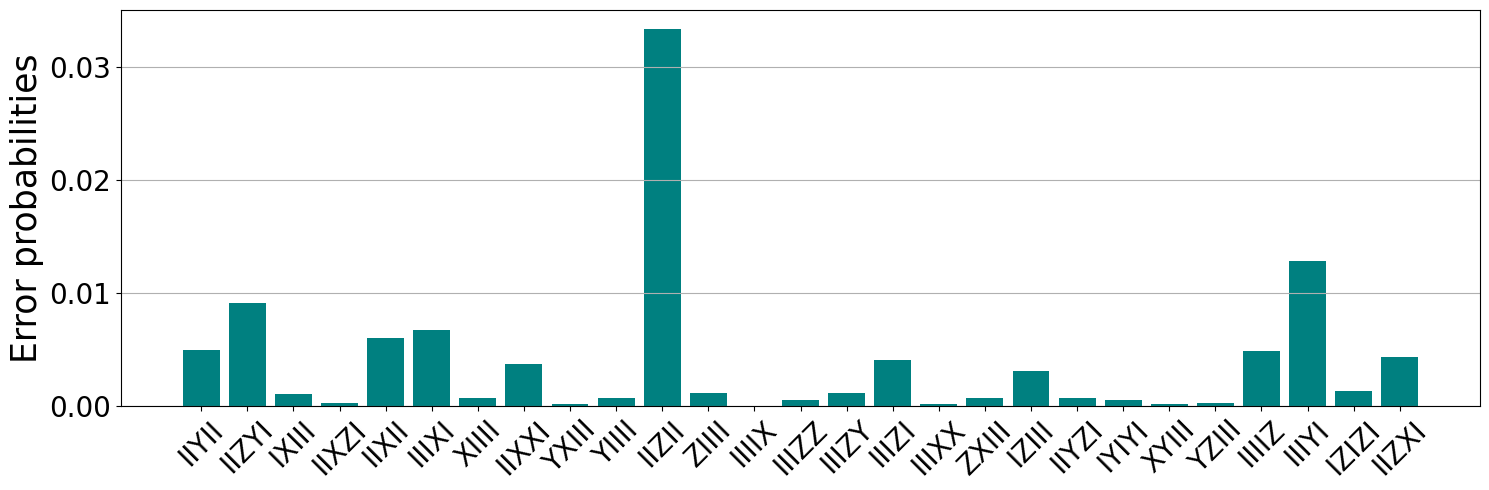

In [23]:
values=[]
for pauli, coeff in data:
    if coeff!=0:
        values.append(mf * coeff)

labels=[]
for pauli, coeff in data:
    if coeff!=0:
        labels.append(str(pauli))

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(labels, values, color="teal")

ax.set_ylabel("Error probabilities", fontsize=25)
ax.tick_params(axis='x', labelsize=20, labelrotation=45)
ax.tick_params(axis='y', labelsize=20)
ax.grid(axis='y')
plt.tight_layout()
# plt.savefig('lambda_coeff.pdf')



In [24]:
# Input SparsePauliOp
pauli_strings = ['IIIII', 'ZZIII', 'IZZII', 'IIZZI', 'IIIZZ']
coeffs = [-2.0 + 0.j, 0.5 + 0.j, 0.5 + 0.j, 0.5 + 0.j, 0.5 + 0.j]

# Convert SparsePauliOp to QuTiP operator
hp_qutip_op = 0
for pauli_string, coeff in zip(pauli_strings, coeffs):
    # Map string to operators
    operators = [pauli_map[char] for char in pauli_string]
    # Create the tensor product
    tensor_op = qt.tensor(*operators)
    # Multiply by the coefficient and add to the final operator
    hp_qutip_op += coeff.real * tensor_op


In [25]:
# Input SparsePauliOp
pauli_strings = ['YZIII', 'ZYIII', 'IYZII', 'IZYII', 'IIYZI', 'IIZYI', 'IIIYZ', 'IIIZY']
coeffs = [1.0 + 0.j, 1.0 + 0.j, 1.0 + 0.j, 1.0 + 0.j, 1.0 + 0.j, 1.0 + 0.j, 1.0 + 0.j, 1.0 + 0.j]

op_qutip_op = 0
for pauli_string, coeff in zip(pauli_strings, coeffs):
    operators = [pauli_map[char] for char in pauli_string]
    tensor_op = qt.tensor(*operators)
    op_qutip_op += coeff.real * tensor_op


In [26]:
pauli_strings = ['XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX']
coeffs = [1 + 0.j, 1 + 0.j, 1 + 0.j, 1 + 0.j, 1 + 0.j]

hd_qutip_op = 0
for pauli_string, coeff in zip(pauli_strings, coeffs):
    operators = [pauli_map[char] for char in pauli_string]
    tensor_op = qt.tensor(*operators)
    hd_qutip_op += coeff.real * tensor_op


In [27]:
gs_energy_qutip_op = hp_qutip_op.eigenstates()[0][0]
print(gs_energy_qutip_op)
gs_qutip_op = hp_qutip_op.eigenstates()[1][0]
rh_qutip_op = gs_qutip_op*gs_qutip_op.dag() 
init_state = tensor(plus, plus, plus, plus, plus)
# rh_qutip_op

-4.0


In [28]:
Ep1_now = []
rho = init_state
states = [init_state]
beta1_now = [0, 0]
final_state = [init_state*init_state.dag()]
h1_now = [0, 1]
stepsss = 20

for i in range(1, stepsss):
    beta_s = interp1d(times1[1:i+2], beta1_now, kind='linear', fill_value="extrapolate")
    hamil_s = interp1d(times1[1:i+2], h1_now, kind='linear', fill_value="extrapolate")

    H_tot_2 = [[hp_qutip_op, coeff_beta(hamil_s, times1[1:i+2])], [hd_qutip_op, coeff_beta(beta_s, times1[1:i+2])]]

    result = mesolve(H_tot_2, init_state, times1[1:i+2], [], [op_qutip_op, hp_qutip_op])
    result_states = mesolve(H_tot_2, init_state, times1[1:i+2], [], [])

    beta = - result.expect[0][-1] 
    beta1_now.append(beta)
    h1_now.append(1)
    Ep1_now.append(result.expect[1][-1])

    state = result_states.states[-1]
    final_state.append(state*state.dag())

In [29]:
r_now = []
for i in range(len(Ep1_now)):
    r_now.append(Ep1_now[i]/gs_energy_qutip_op)
# app_ratio.append(np.array(r))

succ_prob_Ep1_now = []
for i in range(len(final_state)):
    succ_prob_Ep1_now.append(fidelity_qutip(rh_qutip_op, final_state[i]))

In [30]:
succ_prob_Ep_kasf1 = []
for i in range(len(final_state)):
    succ_prob_Ep_kasf1.append(fidelity_qutip(final_state[i], final_state[i]))

(succ_prob_Ep_kasf1)

[1.0000000266182985,
 1.0000000680444412,
 1.0000000690459812,
 1.0000000824250905,
 1.0000000738778518,
 1.0000000763072039,
 1.000000078400405,
 1.0000000721741142,
 1.0000000719336248,
 1.0000000663077153,
 1.000000067072109,
 1.0000000729226424,
 1.0000000762417676,
 1.0000000712921697,
 1.0000000706200052,
 1.0000000682382257,
 1.0000000675615257,
 1.0000000747091013,
 1.0000000644438436,
 1.000000073557785]

In [31]:
Ep_now_open = []
rho = init_state
states = [init_state]
beta1_now_open = [0, 0]
h1_now = [0, 1]
final_state_open = [init_state*init_state.dag()]

options = {"store_final_state": True} 

for i in range(1, stepsss):
    beta_s = interp1d(times1[1:i+2], beta1_now_open, kind='linear', fill_value="extrapolate")
    hamil_s = interp1d(times1[1:i+2], h1_now, kind='linear', fill_value="extrapolate")

    H_tot_2 = [[hp_qutip_op, coeff_beta(hamil_s, times1[1:i+2])], [hd_qutip_op, coeff_beta(beta_s, times1[1:i+2])]]

    result = mesolve(H_tot_2, init_state, times1[1:i+2], c_ops, [op_qutip_op, hp_qutip_op], options= options)
    result_states = mesolve(H_tot_2, init_state, times1[1:i+2], c_ops, [])

    beta = - result.expect[0][-1] 
    beta1_now_open.append(beta)
    h1_now.append(1)
    Ep_now_open.append(result.expect[1][-1])

    state = result_states.states[-1]
    final_state_open.append(result.final_state)

    # final_state_open.append(state*state.dag())

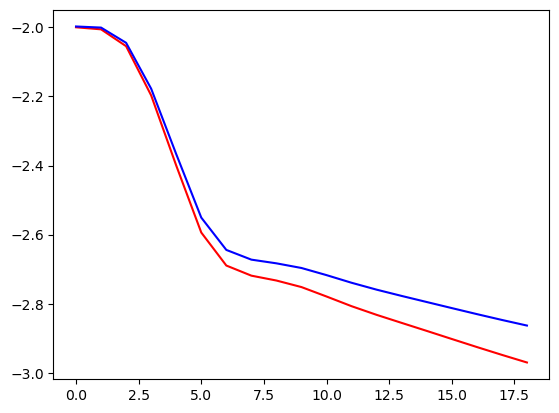

In [ ]:
plt.plot(Ep1_now, 'r') 
plt.plot(Ep_now_open, 'b')

In [ ]:
succ_prob_Ep_now_open = []
for i in range(len(final_state_open)):
    succ_prob_Ep_now_open.append(fidelity_qutip(rh_qutip_op, final_state_open[i]))

r_now_open = []
for i in range(len(Ep_now_open)):
    r_now_open.append(Ep_now_open[i]/gs_energy_qutip_op) 

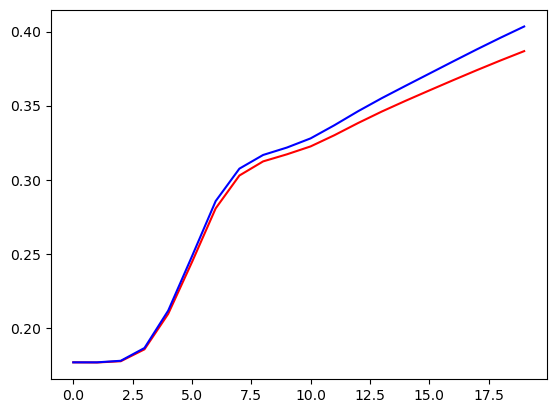

In [ ]:
plt.plot(succ_prob_Ep_now_open,'r')
plt.plot(succ_prob_Ep1_now,'b') 

# print(qt.expect(hp_qutip_op, final_state[-1]))
# print(Ep1_now[-1])


# print(qt.expect(hp_qutip_op, final_state_open[1]))
# print(Ep_now_open[1])


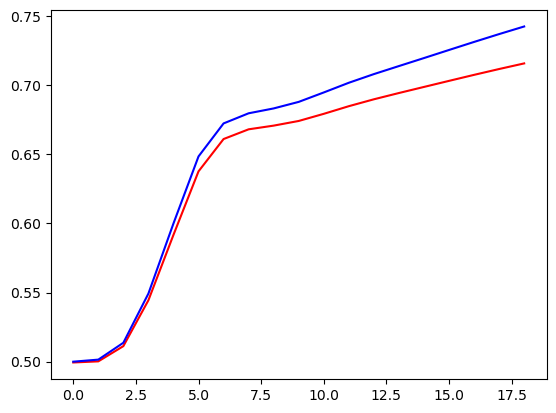

In [ ]:
plt.plot(r_now_open,'r')
plt.plot(r_now,'b') 

In [31]:
ep_now_open_new = []
nomrls = []
for i in range(len(Ep_now_open)):
    # state_n = final_state_open[i]/(final_state_open[i].norm())
    # nomrls.append(state_n.norm())
    ep = qt.expect(hp_qutip_op, final_state_open[i])
    ep_now_open_new.append(ep)

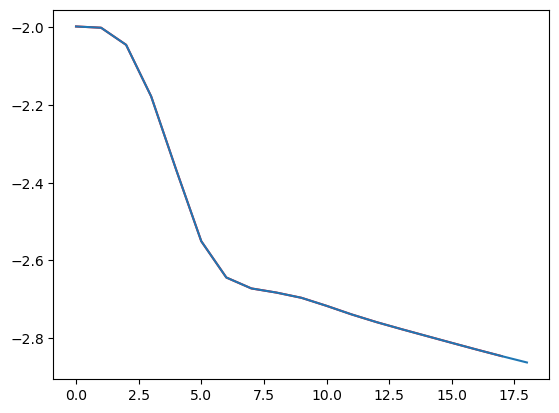

In [32]:
plt.plot(ep_now_open_new[1:], 'r')
plt.plot(Ep_now_open) 

### Open system with Lyapunov controlled gamma rates 

In [33]:
for pauli_string, coeff in data:
    if coeff != 0:  # Skip zero coefficients
        print(pauli_string, coeff)

IIYII 0.000495018435101417
IIZYI 0.0009148370101589832
IXIII 0.00010777432702382785
IIXZI 3.1545884368385507e-05
IIXII 0.0006046326001171507
IIIXI 0.0006719327585057008
XIIII 7.526607900406381e-05
IIXXI 0.00036838238141547255
YXIII 1.6817199893082228e-05
YIIII 6.985366946050551e-05
IIZII 0.0033398655383545996
ZIIII 0.00011313873615702958
IIIIX 3.937691265307485e-06
IIIZZ 5.825477241087637e-05
IIIZY 0.00011872906295227361
IIIZI 0.00041229446224651776
IIIXX 1.635814222551901e-05
ZXIII 7.466961284011499e-05
IZIII 0.00030888065469906155
IIYZI 6.780921625122265e-05
IYIYI 5.195981140560146e-05
XYIII 1.6072548931333763e-05
YZIII 2.3852560101057888e-05
IIIIZ 0.00048762385635260793
IIIYI 0.0012874721005326538
IZIZI 0.0001364588361555782
IIZXI 0.0004380108606459997


In [34]:
# Construct c_ops
# c_ops = 0
OPS = []
gamma_coeffs = []
pauli_strings = []

for pauli_string, coeff in data:
    if coeff != 0:  # Skip zero coefficients
        operators = [pauli_map[char] for char in pauli_string]  # Map string to operators
        tensor_op = qt.tensor(operators)  # Create the tensor product
        second_lyapunov = tensor_op.dag() * hp_qutip_op * tensor_op - hp_qutip_op
        OPS.append(second_lyapunov)
        gamma_coeffs.append(coeff*mf)
        pauli_strings.append(tensor_op)
        
OPS[0]

Quantum object: dims=[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape=(32, 32), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-2.  0.  0. ...  0.  0.  0.]
 [ 0. -2.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0. -2.  0.]
 [ 0.  0.  0. ...  0.  0. -2.]]

In [ ]:
Ep_kasf1 = []
gammv = [0, gamma_coeffs[0]]

rho = init_state
states = [init_state]
beta1_kasf1 = [0, 0]
h1_now = [0, 1]

e_ops = [op_qutip_op, hp_qutip_op, OPS[0]]
nmmc_options = {"map": "parallel"}  # options specific to nm_mcsolve
options = {"progress_bar": "enhanced", "store_final_state": True, "norm_tol" : 1e-6, "norm_steps": 50} 

cc = []
state_f = [init_state*init_state.dag()]
tr = []
ntraj = 100
th = 0.15 

num_traj = []

for i in range(1, 10):
    # print(i)
    beta_s = interp1d(times1[1:i+2], beta1_kasf1, kind='linear', fill_value="extrapolate")
    hamil_s = interp1d(times1[1:i+2], h1_now, kind='linear', fill_value="extrapolate")

    H_tot_2 = [[hp_qutip_op, coeff_beta(hamil_s, times1[1:i+2])], [hd_qutip_op, coeff_beta(beta_s, times1[1:i+2])]]

    gamma_int = CubicSpline(times1[1:i+2], np.complex128(gammv))
    
    # c_ops = [[qt.tensor(si, sy, si), gamma_int]]
    c_ops = [[pauli_strings[0], gamma_int]]

    result = nm_mcsolve(H_tot_2, init_state, times1[1:i+2], c_ops, e_ops, ntraj = ntraj, options=(options | nmmc_options))

    beta = - result.expect[0][-1] 
    beta1_kasf1.append(beta)
    h1_now.append(1)

    b0 = result.expect[2][-1]
    if b0 > th:
        g0 = - th
    else:
        g0 = - b0

    # gammv.append(g0)
    gammv.append(g0)
    Ep_kasf1.append(result.expect[1][-1])

    tr.append(result.trace[-1])
    state_f.append(result.final_state)

    num_traj.append(result.num_trajectories)


 Total run time:   1.52s*] Elapsed 1.49s / Remaining 00:00:00:00
 Total run time:   0.97s*] Elapsed 0.93s / Remaining 00:00:00:00
 Total run time:   1.20s*] Elapsed 1.18s / Remaining 00:00:00:00
 Total run time:   1.10s*] Elapsed 1.08s / Remaining 00:00:00:00[*********42%           ] Elapsed 0.59s / Remaining 00:00:00:00
 Total run time:   1.33s*] Elapsed 1.31s / Remaining 00:00:00:00[*********92%*********  ] Elapsed 1.08s / Remaining 00:00:00:00
 Total run time:   1.04s*] Elapsed 1.02s / Remaining 00:00:00:00
 Total run time:   1.18s*] Elapsed 1.15s / Remaining 00:00:00:00[*********77%******     ] Elapsed 0.88s / Remaining 00:00:00:00
 Total run time:   1.04s*] Elapsed 1.02s / Remaining 00:00:00:00
 Total run time:   1.29s*] Elapsed 1.26s / Remaining 00:00:00:00[*********89%********   ] Elapsed 1.17s / Remaining 00:00:00:00


In [321]:
result.stats

{'method': 'adams',
 'init time': 0.000247955322265625,
 'preparation time': 0.0039010047912597656,
 'run time': 1.294154167175293,
 'solver': 'Master Equation Evolution',
 'num_collapse': 1,
 'end_condition': 'ntraj reached'}

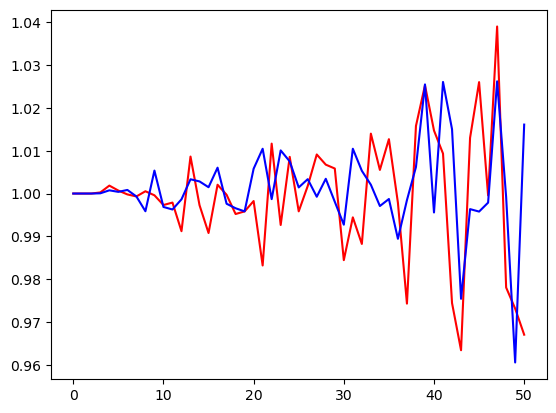

In [320]:
# 10000

ks = [0.9999999999999998, 1.0000000000000906, 0.9999999999999707, 1.0002548243651403, 1.0018519400438675, 1.0006925297894689, 0.9997961037554525, 0.9993194007783436, 1.0005326081298127, 0.9995912216309816, 0.9973193182177567, 0.9978907337456603, 0.9912108202443092, 1.0086283008721402, 0.9972834827387576, 0.9907862551101987, 1.0020541939832563, 0.9997168647713618, 0.9952221120218331, 0.9958299282408802, 0.9982497903081048, 0.9832096829937369, 1.0116489404600333, 0.9926620947676883, 1.0085640868224903, 0.9958424439482604, 1.001769142016312, 1.009116582956849, 1.0067429722999501, 1.0058386336011635, 0.9844570218936094, 0.9944406351846851, 0.9882335246502914, 1.0139766589142887, 1.0055135555920953, 1.0126917713165344, 0.9978343268610845, 0.9743064753187479, 1.0157715190745764, 1.025256637478434, 1.0147072908428436, 1.0093260987332155, 0.9744429506944661, 0.9634308258304252, 1.0130047362796737, 1.0260038933349656, 0.9995597705235107, 1.038991766488914, 0.9780688792080695, 0.9731487592039294, 0.9670548776502647]
lz = [0.9999999999999998, 1.0000000000002267, 0.9999999999999459, 1.0000547673174685, 1.0007490576276277, 1.0003911536316383, 1.0008407755994237, 0.9993227172601974, 0.9958673538421297, 1.0053582425019625, 0.9968695922719285, 0.9962753725191735, 0.99865153898504, 1.0033266488531292, 1.0028270556198136, 1.001476775227972, 1.0060377948520836, 0.9976219160548605, 0.9965643057407001, 0.9958330156668382, 1.0057942472683616, 1.010452886743137, 0.9986896474968197, 1.0100673038028851, 1.0075039651600992, 1.0014297119630393, 1.0033563279440345, 0.9992517567178312, 1.0034420368040922, 0.9980811481337224, 0.9927299521755842, 1.010454754815461, 1.0053061295990864, 1.0020527871889917, 0.9970842745526196, 0.9987253856034246, 0.9894341676456002, 0.9984576830316809, 1.0061957338539211, 1.025467948459556, 0.9955809983134681, 1.0260428517775648, 1.0150109428871803, 0.9754314613225255, 0.996363292941698, 0.9957887343401199, 0.9978752332164557, 1.0261922058927402, 0.9991922304813651, 0.9605701306530778, 1.0160925349700456]

plt.plot(ks,'r')
plt.plot(lz, 'b')
# plt.plot(1*len(lz))

In [316]:
print(num_traj)

[100, 100, 100, 100, 100, 100, 100, 100, 100]


In [292]:
succ_prob_Ep_kasf1 = []
for i in range(len(state_f)):
    succ_prob_Ep_kasf1.append(fidelity_qutip(state_f[i], state_f[i]))

(succ_prob_Ep_kasf1)

[1.0000000266182985,
 1.000000078219729,
 1.000000075429436,
 1.0004552811730045,
 1.0036622085278692,
 1.0178020763484865,
 1.0402984002549014,
 1.0622112466929752,
 1.0856563291819596,
 1.1084493991878015]

In [294]:
succ_prob_Ep_kasf1 = []
for i in range(len(state_f)):
    succ_prob_Ep_kasf1.append(fidelity_qutip(state_f[i], state_f[i]))

(succ_prob_Ep_kasf1)

[1.0000000266182985,
 1.0000000699662956,
 1.000000071509667,
 1.0004552774050952,
 1.0036622120530287,
 1.0178020801933625,
 1.0421130065707875,
 1.0622112466135425,
 1.0856563384546678,
 1.108449402876147]

In [272]:
st = state_f[2]
st
qt.fidelity(st, st)

1.0000000650079637

In [288]:
tr

[1.0,
 1.0,
 1.0004552085891896,
 1.003662132016718,
 1.0178020018085763,
 1.0421129307109154,
 1.0622111752978503,
 1.0856562644441852,
 1.1084493241193891]

In [274]:
tr_new = []
for i in range(len(state_f)):
    tr_new.append(state_f[i].tr())


tr_new

[0.9999999999999998,
 1.0000000000000004,
 0.9999999999999998,
 1.0004552085891896,
 1.003662132016718,
 1.0178020018085763,
 1.0421129307109152,
 1.0622111752978496,
 0.868525011555348,
 1.1084493241193891]

In [ ]:
print(qt.expect(hp_qutip_op, final_state[-1]))
print(Ep1_now[-1])


print(qt.expect(hp_qutip_op, final_state_open[10]))
print(Ep_now_open[10])

print(qt.expect(hp_qutip_op, state_f[-1]))
print(Ep_kasf1[-1])

-2.969757445784028
-2.969757445784028
-2.696404870265329
-2.717034708093274
-2.703721919792109
-2.703721919792108


In [ ]:
print(fidelity_qutip(state_f[7], state_f[7]))
print(tr)

print(1/1.0101489799125636 * state_f[7].tr())

# tr = []
# for i in range(len(Ep_kasf1)):
#     tr.append()

1.062211237578598
[1.0, 1.0, 1.0004552085891882, 1.0036621320167176, 0.9974459617724045, 1.021270672096696, 0.9347458342621064, 0.9553775127108814, 0.9754354052250633]
0.9253544307326014


In [ ]:
st = state_f[8] / ((state_f[8]).norm())
print((state_f[8]).norm())
st.norm()


1.0856562644441887


1.0

In [ ]:
succ_prob_Ep_kasf1 = []

for i in range(len(state_f)):
    succ_prob_Ep_kasf1.append(fidelity_qutip(rh_qutip_op, state_f[i]))

r_now_kasf1 = []
for i in range(len(Ep_kasf1)):
    r_now_kasf1.append(Ep_kasf1[i]/gs_energy_qutip_op)

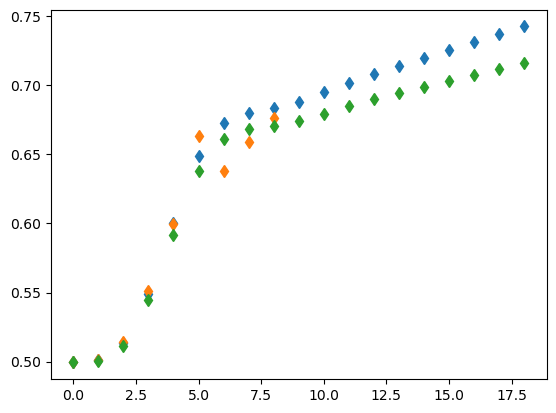

In [ ]:
k = 25
plt.plot(r_now[0:k],'d')
plt.plot(r_now_kasf1[0:k], 'd')
plt.plot(r_now_open[0:k],'d')


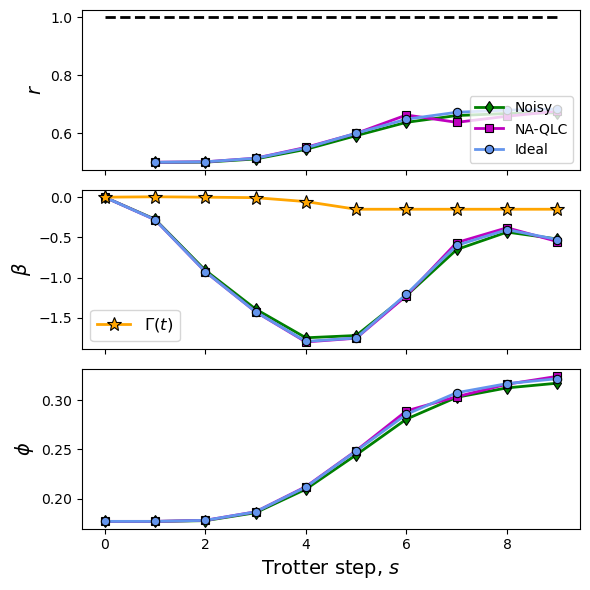

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

k = 9
x= np.arange(1, k+1)

axes[0].plot(x, r_now_open[0:k], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Noisy')
axes[0].plot(x, r_now_kasf1[0:k], color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-QLC')
axes[0].plot(x, r_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Ideal')
axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
# axes[0].plot(tr)
axes[0].set_ylabel(r"$r$", fontsize=14)
axes[0].legend(fontsize=10, loc = 'lower right')
axes[0].tick_params(axis='x', labelsize=15)
# axes[0].legend()
# axes[0].text(2.4, 0.73, "(a)", fontsize=10, fontweight='bold')

axes[1].plot(beta1_now_open[1:k+2], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
axes[1].plot(beta1_kasf1[1:k+2], color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
axes[1].plot(beta1_now[1:k+2], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
axes[1].plot(gammv[0:k+1], color = 'orange', marker = '*', markersize = '10', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = r"$\Gamma(t)$")

axes[1].legend(fontsize=12)
axes[1].set_ylabel(r"$\beta$", fontsize=14)
# axes[1].text(2.4, -0.35, "(b)", fontsize=10, fontweight='bold')


k = 10
axes[2].plot(succ_prob_Ep_now_open[0:k], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Open quantum system')
axes[2].plot(succ_prob_Ep_kasf1[0:k], color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-QLC')
axes[2].plot(succ_prob_Ep1_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Closed quatum system')
# axes[2].plot([1]*21,linestyle='--', linewidth=2, color = 'black')
# axes[2].legend()
axes[2].set_ylabel(r"$\phi$",fontsize=14)
axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
# axes[2].text(2.4, 0.38, "(c)", fontsize=10, fontweight='bold')

plt.tight_layout()
# filename = f"Maxcut_5q.pdf"  # Creates "plot_experiment1.png"
# filename = f"Plot1_dt_0.05_mf_5_ntraj_3000_type1_steps40.pdf"
# plt.savefig(filename)
plt.show()


In [41]:
k = 25
kasturi = [r_now_open[0:k], r_now_kasf1[0:k], r_now[0:k]]
file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj}_th_{th}_type1.npy'  

# Write the array to a file
np.save(file_path, kasturi)

In [42]:
k = k+1

kasturi = [succ_prob_Ep_now_open[0:k], succ_prob_Ep_kasf1[0:k], succ_prob_Ep1_now[0:k]]
file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj}_th_{th}_type1.npy'

# Write the array to a file
np.save(file_path, kasturi)

In [43]:
k = k+1
kasturi = [beta1_now_open[1:k], beta1_kasf1[1:k], beta1_now[1:k]]
file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj}_th_{th}_type1.npy'

# Write the array to a file
np.save(file_path, kasturi)

In [44]:
kasturi = gammv
file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj}_th_{th}_type1.npy'

# Write the array to a file
np.save(file_path, kasturi)

In [ ]:
kasturi = tr
file_path = f'data_5q/tr_mf_{mf}_dt_{dt}_ntraj_{ntraj}_th_{th}_type1.npy'

# Write the array to a file
np.save(file_path, kasturi)

## LOAD FILES AND PLOT

In [2]:
ntraj1 = 12000
mf = 10
dt = 0.07


file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type2.npy'
agp_arr = np.load(file_path)

r_now_open, r_now_kasf1, r_now = agp_arr[0], agp_arr[1], agp_arr[2]


file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type2.npy'
agp_arr3 = np.load(file_path)
succ_prob_Ep_now_open, succ_prob_Ep_kasf1, succ_prob_Ep1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]

file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type2.npy'
agp_arr2 = np.load(file_path)
beta1_now_open, beta1_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]


file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type2.npy'
gammv = np.load(file_path)

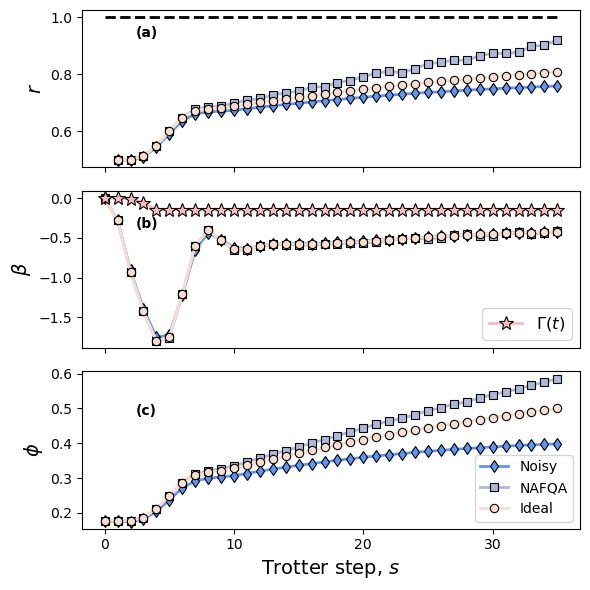

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

colors = ['#6495ED','#AEB9D7', '#F8DED1', '#F6BDC0']
# colors = ['g', 'm', '#6495ED', 'orange']

k = 35
x= np.arange(1, k+1)

axes[0].plot(x, r_now_open[0:k], color = colors[0], marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Noisy')
axes[0].plot(x, r_now_kasf1[0:k], color = colors[1], marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-FQA')
axes[0].plot(x, r_now[0:k], color = colors[2], marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Ideal')
axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
# axes[0].plot(tr)
axes[0].set_ylabel(r"$r$", fontsize=14)
# axes[0].legend(fontsize=10, loc = 'lower right')
axes[0].tick_params(axis='x', labelsize=15)
# axes[0].legend()
axes[0].text(2.4, 0.93, "(a)", fontsize=10, fontweight='bold')

axes[1].plot(beta1_now_open[0:k+1], color = colors[0], marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
axes[1].plot(beta1_kasf1[0:k+1], color =  colors[1], marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
axes[1].plot(beta1_now[0:k+1], color =  colors[2], marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
axes[1].plot(gammv[1:k+2], color = colors[3], marker = '*', markersize = '10', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = r"$\Gamma(t)$")

axes[1].legend(fontsize=12)
axes[1].set_ylabel(r"$\beta$", fontsize=14)
axes[1].text(2.4, -0.38, "(b)", fontsize=10, fontweight='bold')


k = 36
axes[2].plot(succ_prob_Ep_now_open[0:k], color =  colors[0], marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Noisy')
axes[2].plot(succ_prob_Ep_kasf1[0:k], color =  colors[1], marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NAFQA')
axes[2].plot(succ_prob_Ep1_now[0:k], color =  colors[2], marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Ideal')
# axes[2].plot([1]*21,linestyle='--', linewidth=2, color = 'black')
axes[2].legend(fontsize=10, loc = 'lower right')
axes[2].set_ylabel(r"$\phi$",fontsize=14)
axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
axes[2].text(2.4, 0.48, "(c)", fontsize=10, fontweight='bold')

plt.tight_layout()
filename = f"Maxcut_5q.pdf"  
# # filename = f"Plot1_dt_0.05_mf_5_ntraj_3000_type1_steps40.pdf"
plt.savefig(filename)
plt.show()


## Plot as a function of time 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


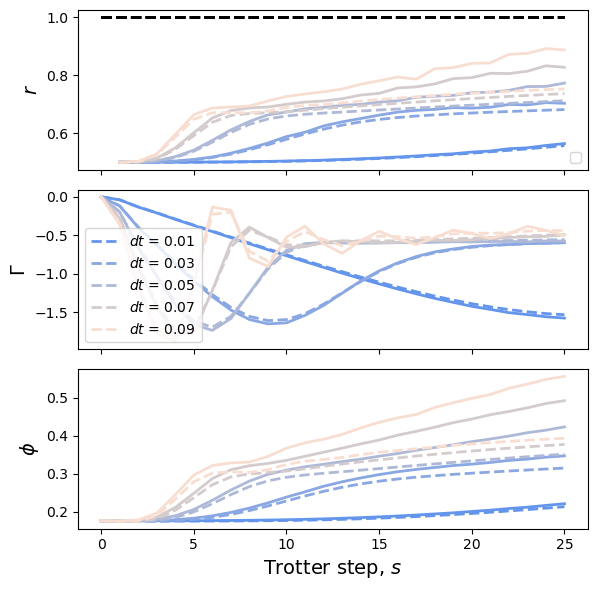

In [505]:
ntraj1 = 12000
mf = 10
# dt = 0.05

cases = [0.01, 0.03, 0.05, 0.07, 0.09]
colors = ['#6495ED', '#89A7E2', '#AEB9D7', '#D3CBCC', '#F8DED1', '#F6BDC0']
# colors = ['blue', 'orange', 'g', 'purple', 'olive']


fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

for i, dt in enumerate(cases):

    file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    agp_arr = np.load(file_path)

    r_now_open, r_now_kasf1, r_now = agp_arr[0], agp_arr[1], agp_arr[2]


    file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_Ep_now_open, succ_prob_Ep_kasf1, succ_prob_Ep1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]

    file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    agp_arr2 = np.load(file_path)
    beta1_now_open, beta1_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]


    file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    gammv = np.load(file_path)

    k = 25
    x= np.arange(1, k+1)

    axes[0].plot(x, r_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[0].plot(x, r_now_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    # axes[0].plot(x, r_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Ideal')
    axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
    # axes[0].plot(tr)
    axes[0].set_ylabel(r"$r$", fontsize=14)
    axes[0].legend(fontsize=10, loc = 'lower right')
    axes[0].tick_params(axis='x', labelsize=15)
    # axes[0].legend()
    # axes[0].text(2.4, 0.73, "(a)", fontsize=10, fontweight='bold')

    axes[1].plot(beta1_now_open[0:k+1], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black',  label = f'$dt$ = {dt}')
    axes[1].plot(beta1_kasf1[0:k+1], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    # axes[1].plot(beta1_now[0:k+1], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    # axes[1].plot(gammv[1:k+2], color =  colors[i], markersize = '10', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black',  label = f'$dt$ = {dt}')

    axes[1].legend(fontsize=10)
    axes[1].set_ylabel(r"$\Gamma$", fontsize=14)
    # axes[1].text(2.4, -0.35, "(b)", fontsize=10, fontweight='bold')


    k = 26
    axes[2].plot(succ_prob_Ep_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Open quantum system')
    axes[2].plot(succ_prob_Ep_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-FQA')
    # axes[2].plot(succ_prob_Ep1_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Closed quatum system')
    # axes[2].plot([1]*21,linestyle='--', linewidth=2, color = 'black')
    # axes[2].legend()
    axes[2].set_ylabel(r"$\phi$",fontsize=14)
    axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
    # axes[2].text(2.4, 0.38, "(c)", fontsize=10, fontweight='bold')

plt.tight_layout()
# filename = f"demo_2.pdf" 
# plt.savefig(filename)
plt.show()


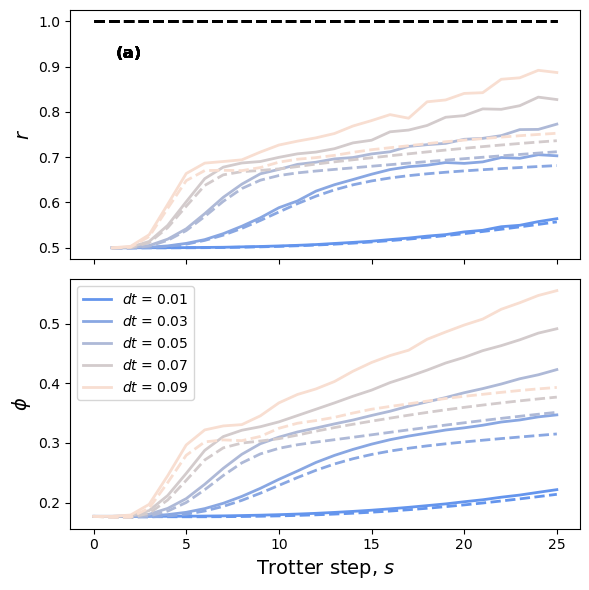

In [6]:
ntraj1 = 12000
mf = 10
# dt = 0.05

cases = [0.01, 0.03, 0.05, 0.07, 0.09]
colors = ['#6495ED', '#89A7E2', '#AEB9D7', '#D3CBCC', '#F8DED1', '#F6BDC0']
# colors = ['blue', 'orange', 'g', 'purple', 'olive']


fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

for i, dt in enumerate(cases):

    file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    agp_arr = np.load(file_path)

    r_now_open, r_now_kasf1, r_now = agp_arr[0], agp_arr[1], agp_arr[2]


    file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_Ep_now_open, succ_prob_Ep_kasf1, succ_prob_Ep1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]

    file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    agp_arr2 = np.load(file_path)
    beta1_now_open, beta1_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]


    file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    gammv = np.load(file_path)

    k = 25
    x= np.arange(1, k+1)

    axes[0].text(1.2, 0.92, "(a)", fontsize=12, fontweight='bold')
    axes[0].plot(x, r_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[0].plot(x, r_now_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    # axes[0].plot(x, r_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Ideal')
    axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
    # axes[0].plot(tr)
    axes[0].set_ylabel(r"$r$", fontsize=14)
    # axes[0].legend(fontsize=10, loc = 'lower right')
    axes[0].tick_params(axis='x', labelsize=15)
    # axes[0].legend()
    # axes[0].text(2.4, 0.73, "(a)", fontsize=10, fontweight='bold')

    k = 26
    axes[1].plot(succ_prob_Ep_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(succ_prob_Ep_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = f'$dt$ = {dt}')
    axes[1].legend(fontsize=10)
    axes[1].set_ylabel(r"$\phi$",fontsize=14)
    axes[1].set_xlabel(r"Trotter step, $s$", fontsize=14)
    # axes[2].text(2.4, 0.38, "(c)", fontsize=10, fontweight='bold')

plt.tight_layout()
filename = f"demo_2.pdf" 
plt.savefig(filename)
plt.show()


## Plot as a function of no. of samples

0
1
2
3
4


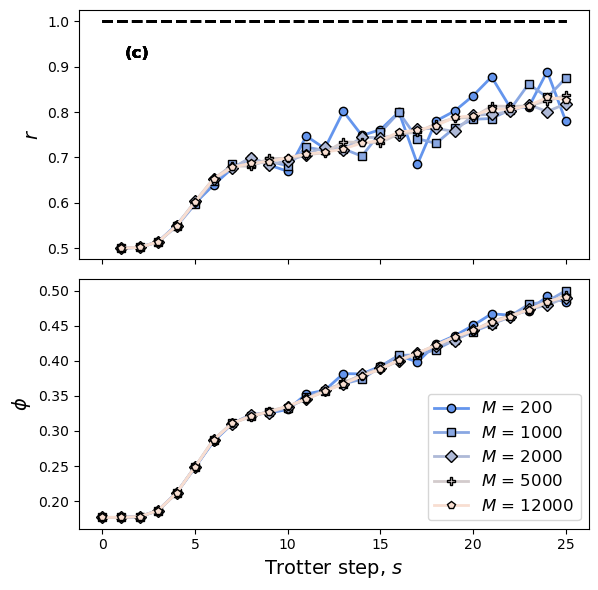

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm

mf = 10
dt = 0.07
ntraj = 500
nota = [200, 1000, 2000, 5000, 12000]
colors = ['#6495ED', '#89A7E2', '#AEB9D7', '#D3CBCC', '#F8DED1', '#F6BDC0']
# colors = ['blue', 'orange', 'g', 'purple', 'olive']
# colors = cm.viridis(np.linspace(0, 1, len(x)))

markers = ['o', 's', 'D', 'P', 'p', '1']

fig, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True)
k = 25

delta_t = [dt]

file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'
gammv = np.load(file_path)

i = 0 
init = 0
x= np.arange(init+1, k+1)

for ntraj in nota:
    print(i)
    file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'

    agp_arr = np.load(file_path)
    r_now_open, r_kasf1, r1_now = agp_arr[0], agp_arr[1], agp_arr[2]

    # file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'
    # agp_arr2 = np.load(file_path)
    # beta_now_open, beta_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]

    file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_now_open, succ_prob_kasf1, succ_prob1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]


    # Subplot (a) ⟨Hp⟩
    axes[0].text(1.2, 0.92, "(c)", fontsize=12, fontweight='bold')
    axes[0].plot(x, r_kasf1[init:k],  color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='-', linewidth=2, 
                markersize=6, markeredgewidth=1, markeredgecolor='black', label=f'$M$ = {ntraj}')
    axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
    axes[0].set_ylabel(r"$r$", fontsize=14)
    axes[0].tick_params(axis='x', labelsize=15)
    # axes[0].text(1.2, 0.90, "(c)", fontsize=10, fontweight='bold')


    # axes[1].plot(beta_kasf1[init:k+1], color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='-', linewidth=2, 
    #             markersize=6, markeredgewidth=1, markeredgecolor='black')
    # axes[1].set_ylabel(r"$\beta$", fontsize=14)

    axes[1].plot(succ_prob_kasf1[init:k+1], color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='-', linewidth=2, 
                markersize=6, markeredgewidth=1, markeredgecolor='black', label=f'$M$ = {ntraj}')
    axes[1].set_ylabel(r"$\phi$",fontsize=14)
    axes[1].set_xlabel(r"Trotter step, $s$", fontsize=14)
    axes[1].legend(fontsize=12, loc='lower right')

    # axes[1].legend(loc = 'lower right', bbox_to_anchor=(2.15, -0.3), ncol = 5, fontsize=12)
    i += 1

# Adjust layout
plt.tight_layout()
filename = f"ntraj_demo.pdf" 
plt.savefig(filename)
plt.show()


## Plot as a function of thresold value

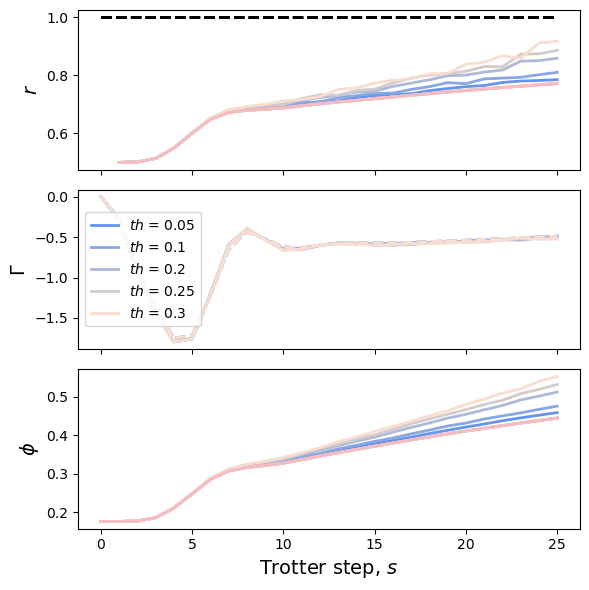

In [ ]:
ntraj1 = 12000
mf = 10
dt = 0.07

cases = [0.05, 0.1, 0.2, 0.25, 0.3]
colors = ['#6495ED', '#89A7E2', '#AEB9D7', '#D3CBCC', '#F8DED1', '#F6BDC0']
# colors = ['blue', 'orange', 'g', 'purple', 'olive']


fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

for i, th in enumerate(cases):

    file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    agp_arr = np.load(file_path)

    r_now_open, r_now_kasf1, r_now = agp_arr[0], agp_arr[1], agp_arr[2]


    file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_Ep_now_open, succ_prob_Ep_kasf1, succ_prob_Ep1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]

    file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    agp_arr2 = np.load(file_path)
    beta1_now_open, beta1_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]


    file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    gammv = np.load(file_path)

    k = 25
    x= np.arange(1, k+1)

    

    # axes[0].plot(x, r_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[0].plot(x, r_now_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[0].plot(x, r_now[0:k], color = '#F6BDC0', linestyle='-', linewidth=2, label = 'Ideal')
    axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
    # axes[0].plot(tr)
    axes[0].set_ylabel(r"$r$", fontsize=14)
    # axes[0].legend(fontsize=10, loc = 'lower right')
    axes[0].tick_params(axis='x', labelsize=15)
    # axes[0].legend()
    # axes[0].text(2.4, 0.73, "(a)", fontsize=10, fontweight='bold')

    axes[1].plot(beta1_now_open[0:k+1], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(beta1_kasf1[0:k+1], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black',  label = f'$th$ = {th}')
    # axes[1].plot(beta1_now[0:k+1], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    # axes[1].plot(gammv[1:k+2], color =  colors[i], markersize = '10', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black',  label = f'$dt$ = {dt}')

    axes[1].legend(fontsize=10)
    axes[1].set_ylabel(r"$\Gamma$", fontsize=14)
    # axes[1].text(2.4, -0.35, "(b)", fontsize=10, fontweight='bold')


    k = 26
    # axes[2].plot(succ_prob_Ep_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Open quantum system')
    axes[2].plot(succ_prob_Ep_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-FQA')
    axes[2].plot(succ_prob_Ep1_now[0:k], color = '#F6BDC0', linestyle='-', linewidth=2, label = 'Closed quatum system')
    # axes[2].plot([1]*21,linestyle='--', linewidth=2, color = 'black')
    # axes[2].legend()
    axes[2].set_ylabel(r"$\phi$",fontsize=14)
    axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
    # axes[2].text(2.4, 0.38, "(c)", fontsize=10, fontweight='bold')

plt.tight_layout()
# filename = f"demo_2.pdf" 
# plt.savefig(filename)
plt.show()


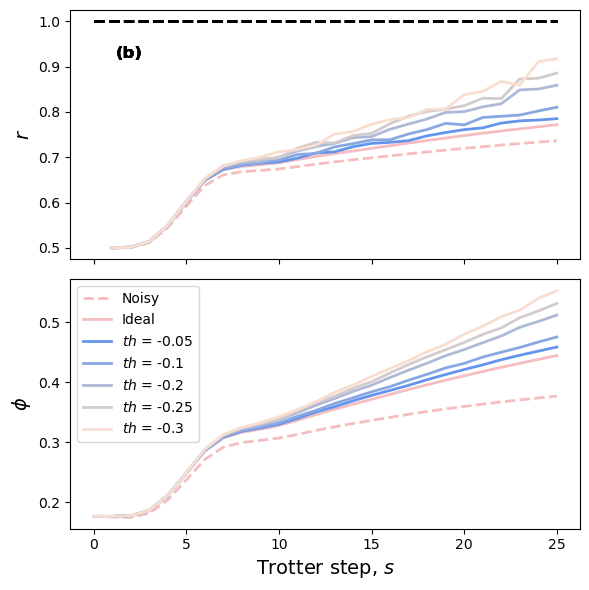

In [12]:
ntraj1 = 12000
mf = 10
dt = 0.07

cases = [0.05, 0.1, 0.2, 0.25, 0.3]
colors = ['#6495ED', '#89A7E2', '#AEB9D7', '#D3CBCC', '#F8DED1', '#F6BDC0']
# colors = ['blue', 'orange', 'g', 'purple', 'olive']


fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

th = 0.05

file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
agp_arr = np.load(file_path)

r_now_open, r_now_kasf1, r_now = agp_arr[0], agp_arr[1], agp_arr[2]

axes[0].plot(x, r_now_open[0:k], color = '#F6BDC0', linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Noisy')
axes[0].plot(x, r_now[0:k], color = '#F6BDC0', linestyle='-', linewidth=2, label = 'Ideal')


for i, th in enumerate(cases):

    file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    agp_arr = np.load(file_path)

    r_now_open, r_now_kasf1, r_now = agp_arr[0], agp_arr[1], agp_arr[2]


    file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_Ep_now_open, succ_prob_Ep_kasf1, succ_prob_Ep1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]

    file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    agp_arr2 = np.load(file_path)
    beta1_now_open, beta1_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]


    file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    gammv = np.load(file_path)

    k = 25
    x= np.arange(1, k+1)

    axes[0].text(1.2, 0.92, "(b)", fontsize=12, fontweight='bold')
    # axes[0].plot(x, r_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[0].plot(x, r_now_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = f'$th$ = {-th}')
    # axes[0].plot(x, r_now[0:k], color = '#F6BDC0', linestyle='-', linewidth=2, label = 'Ideal')
    axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
    # axes[0].plot(tr)
    axes[0].set_ylabel(r"$r$", fontsize=14)
    # axes[0].legend(fontsize=10, loc = 'lower right')
    axes[0].tick_params(axis='x', labelsize=15)
    # axes[0].legend(fontsize = 10, loc = 'center left')
    # axes[0].text(2.4, 0.73, "(a)", fontsize=10, fontweight='bold')

    k = 26
    if i == 0:
        axes[1].plot(succ_prob_Ep_now_open[0:k], color = '#F6BDC0', linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Noisy')
        axes[1].plot(succ_prob_Ep1_now[0:k], color = '#F6BDC0', linestyle='-', linewidth=2, label = 'Ideal')

    axes[1].plot(succ_prob_Ep_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = f'$th$ = {-th}')
    # axes[2].plot([1]*21,linestyle='--', linewidth=2, color = 'black')
    # axes[2].legend()
    axes[1].set_ylabel(r"$\phi$",fontsize=14)
    axes[1].set_xlabel(r"Trotter step, $s$", fontsize=14)
    axes[1].legend(fontsize = 10, loc = 'upper left')

    # axes[2].text(2.4, 0.38, "(c)", fontsize=10, fontweight='bold')


plt.tight_layout()
filename = f"demo_3.pdf" 
plt.savefig(filename)
plt.show()


In [134]:
ntraj1 = 20000
file_path = f'data/r_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
agp_arr = np.load(file_path)

r_now_open_ntraj1, r_kasf1_ntraj1, r1_now_ntraj1 = agp_arr[0], agp_arr[1], agp_arr[2]


file_path = f'data/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
agp_arr3 = np.load(file_path)
succ_prob_now_open_ntraj1, succ_prob_kasf1_ntraj1, succ_prob1_now_ntraj1 = agp_arr3[0], agp_arr3[1], agp_arr3[2]

file_path = f'data/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
agp_arr2 = np.load(file_path)
beta_now_open_ntraj1, beta_kasf1_ntraj1, beta1_now_ntraj1 = agp_arr2[0], agp_arr2[1], agp_arr2[2]

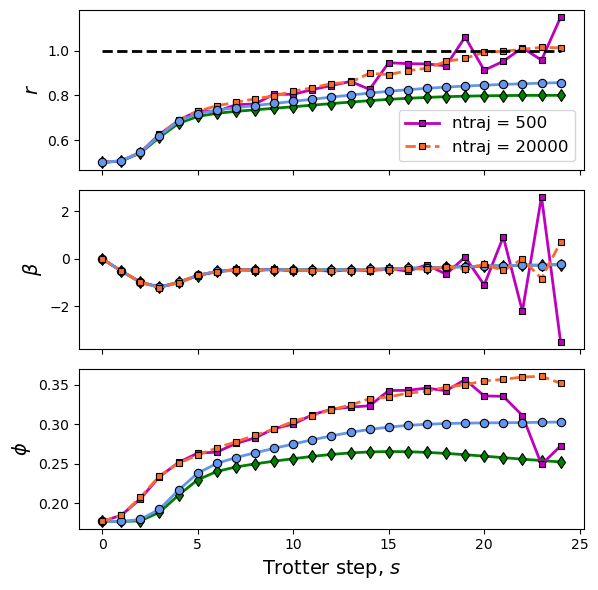

In [143]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
k = 25
delta_t = [dt]

file_path = f'data/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'
gammv = np.load(file_path)

for dt in delta_t:
    file_path = f'data/r_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'

    agp_arr = np.load(file_path)
    r_now_open, r_kasf1, r1_now = agp_arr[0], agp_arr[1], agp_arr[2]

    file_path = f'data/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'
    agp_arr2 = np.load(file_path)
    beta_now_open, beta_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]

    file_path = f'data/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_now_open, succ_prob_kasf1, succ_prob1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]


    # Subplot (a) ⟨Hp⟩
    axes[0].plot(r_now_open[0:k], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[0].plot(r_kasf1[0:k], color = 'm', marker = 's', markersize = '5', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'ntraj = 500')
    
    axes[0].plot(r_kasf1_ntraj1[0:k],  color = '#FB6A2C', marker = 's', markersize = '5', linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'ntraj = 20000')

    axes[0].plot(r1_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[0].plot([1]*k,linestyle='--', linewidth=2, color = 'black')
    axes[0].set_ylabel(r"$r$", fontsize=14)
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].legend(fontsize=12)
    # axes[0].text(1.2, 0.87, "(a)", fontsize=10, fontweight='bold')

    axes[1].plot(beta_now_open[0:k], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(beta_kasf1[0:k], color = 'm', marker = 's', markersize = '5', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(beta1_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(beta_kasf1_ntraj1[0:k],  color = '#FB6A2C', marker = 's', markersize = '5', linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-QLC')

    # axes[1].plot(gammv[0][0:k], color = 'orange', marker = '*', markersize = '10', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = r"$\lambda(t)$")

    # axes[1].legend(fontsize=10)
    axes[1].set_ylabel(r"$\beta$", fontsize=14)
    # axes[1].text(1.2, -0.25, "(b)", fontsize=10, fontweight='bold')
    # axes[1].legend(fontsize=11)

    # axes[1].set_xlim(0, 11)
    # axes[1].set_ylim(-2.2, -1)

    axes[2].plot(succ_prob_now_open[0:k], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Open quantum system')
    axes[2].plot(succ_prob_kasf1[0:k], color = 'm', marker = 's', markersize = '5', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-QLC')
    axes[2].plot(succ_prob1_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Closed quatum system')
    axes[2].plot(succ_prob_kasf1_ntraj1[0:k], color = '#FB6A2C', marker = 's', markersize = '5', linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-QLC')

    # axes[2].legend()
    axes[2].set_ylabel(r"$\phi$",fontsize=14)
    axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
    # axes[2].text(1.2, 0.32, "(c)", fontsize=10, fontweight='bold')

# Adjust layout
plt.tight_layout()
filename = f"Comaprison_dt_{dt}_mf_{mf}.pdf"  # Creates "plot_experiment1.png"
plt.savefig(filename)
plt.show()


In [154]:
dt = 0.15
mf = 10
ntraj = 10000

1


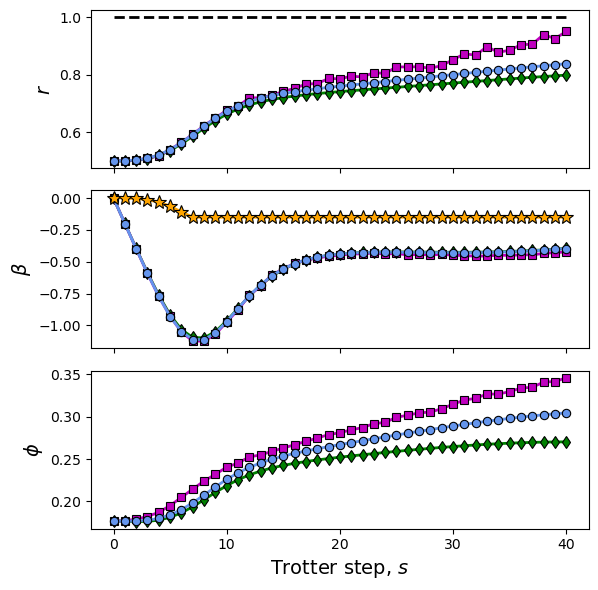

In [99]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
k = 41
delta_t = [dt]

file_path = f'data/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'
gammv = np.load(file_path)
print(len(gammv[0:k]))

for dt in delta_t:
    file_path = f'data/r_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'

    agp_arr = np.load(file_path)
    r_now_open, r_kasf1, r1_now = agp_arr[0], agp_arr[1], agp_arr[2]

    file_path = f'data/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'
    agp_arr2 = np.load(file_path)
    beta_now_open, beta_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]

    file_path = f'data/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_now_open, succ_prob_kasf1, succ_prob1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]


    # Subplot (a) ⟨Hp⟩
    axes[0].plot(r_now_open[0:k], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Open quantum system')
    axes[0].plot(r_kasf1[0:k], color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-QLC')
    axes[0].plot(r1_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Closed quatum system')
    axes[0].plot([1]*k,linestyle='--', linewidth=2, color = 'black')
    axes[0].set_ylabel(r"$r$", fontsize=14)
    axes[0].tick_params(axis='x', labelsize=15)
    # axes[0].legend(fontsize=11)
    # axes[0].text(1.2, 0.87, "(a)", fontsize=10, fontweight='bold')

    axes[1].plot(beta_now_open[0:k], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(beta_kasf1[0:k], color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(beta1_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(gammv[0][0][0:k], color = 'orange', marker = '*', markersize = '10', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = r"$\lambda(t)$")

    # axes[1].legend(fontsize=10)
    axes[1].set_ylabel(r"$\beta$", fontsize=14)
    # axes[1].text(1.2, -0.25, "(b)", fontsize=10, fontweight='bold')
    # axes[1].legend(fontsize=11)

    # axes[1].set_xlim(0, 11)
    # axes[1].set_ylim(-2.2, -1)

    axes[2].plot(succ_prob_now_open[0:k], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Open quantum system')
    axes[2].plot(succ_prob_kasf1[0:k], color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-QLC')
    axes[2].plot(succ_prob1_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Closed quatum system')
    # axes[2].legend()
    axes[2].set_ylabel(r"$\phi$",fontsize=14)
    axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
    # axes[2].text(1.2, 0.32, "(c)", fontsize=10, fontweight='bold')

# Adjust layout
plt.tight_layout()
filename = f"Plot1_dt_{dt}_mf_{mf}_ntraj_{ntraj}_type1_steps40.pdf"  # Creates "plot_experiment1.png"
plt.savefig(filename)

plt.show()


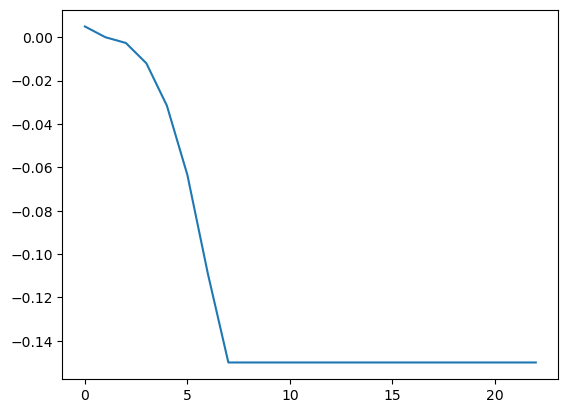

In [90]:
plt.plot(gammv[0][0][0:k])

In [173]:
dt = 0.15
mf = 10
ntraj = 10000

FileNotFoundError: [Errno 2] No such file or directory: 'data/gamma_mf_5_dt_0.05_ntraj_3000.npy'

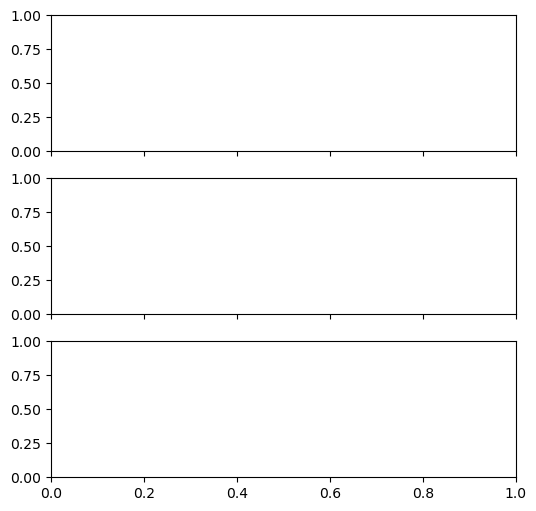

In [69]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
k = 10
delta_t = [dt]

file_path = f'data/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj}.npy'
gammv = np.load(file_path)

for dt in delta_t:
    file_path = f'data/r_mf_{mf}_dt_{dt}_ntraj_{ntraj}.npy'

    agp_arr = np.load(file_path)
    r_now_open, r_kasf1, r1_now = agp_arr[0], agp_arr[1], agp_arr[2]

    file_path = f'data/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj}.npy'
    agp_arr2 = np.load(file_path)
    beta_now_open, beta_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]

    file_path = f'data/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj}.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_now_open, succ_prob_kasf1, succ_prob1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]


    # Subplot (a) ⟨Hp⟩
    axes[0].plot(r_now_open, color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Open quantum system')
    axes[0].plot(r_kasf1, color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-QLC')
    axes[0].plot(r1_now, color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Closed quatum system')
    axes[0].set_ylabel(r"$r$", fontsize=14)
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].legend(fontsize=11)
    # axes[0].text(1.2, 0.87, "(a)", fontsize=10, fontweight='bold')

    axes[1].plot(beta_now_open, color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(beta_kasf1, color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(beta1_now, color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(gammv[0], color = 'orange', marker = '*', markersize = '10', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = r"$\lambda(t)$")

    axes[1].legend(fontsize=12)
    axes[1].set_ylabel(r"$\beta$", fontsize=14)
    # axes[1].text(1.2, -0.25, "(b)", fontsize=10, fontweight='bold')
    axes[1].legend(fontsize=11)

    # axes[1].set_xlim(0, 11)
    # axes[1].set_ylim(-2.2, -1)

    axes[2].plot(succ_prob_now_open, color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Open quantum system')
    axes[2].plot(succ_prob_kasf1, color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-QLC')
    axes[2].plot(succ_prob1_now, color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Closed quatum system')
    # axes[2].legend()
    axes[2].set_ylabel(r"$\phi$",fontsize=14)
    axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
    # axes[2].text(1.2, 0.32, "(c)", fontsize=10, fontweight='bold')

# Adjust layout
plt.tight_layout()
filename = f"Plot1_dt_{dt}_mf_{mf}_ntraj_{ntraj}.pdf"  # Creates "plot_experiment1.png"
plt.savefig(filename)

plt.show()


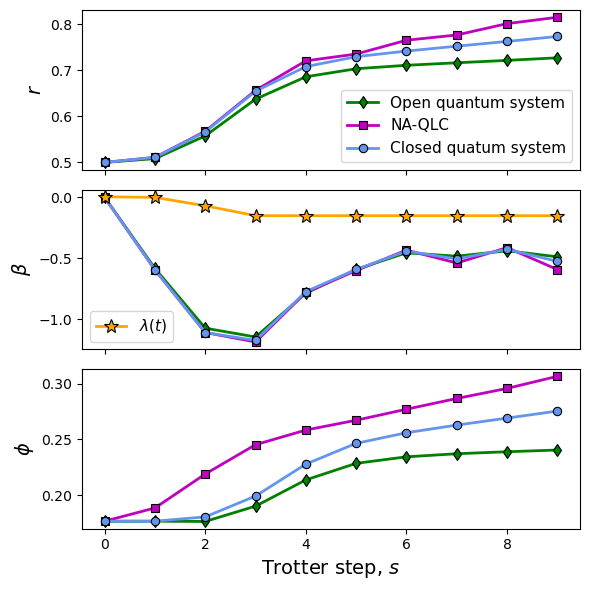

In [176]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
k = 10
delta_t = [dt]

file_path = f'data/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj}.npy'
gammv = np.load(file_path)

for dt in delta_t:
    file_path = f'data/r_mf_{mf}_dt_{dt}_ntraj_{ntraj}.npy'

    agp_arr = np.load(file_path)
    r_now_open, r_kasf1, r1_now = agp_arr[0], agp_arr[1], agp_arr[2]

    file_path = f'data/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj}.npy'
    agp_arr2 = np.load(file_path)
    beta_now_open, beta_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]

    file_path = f'data/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj}.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_now_open, succ_prob_kasf1, succ_prob1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]


    # Subplot (a) ⟨Hp⟩
    axes[0].plot(r_now_open[0:k], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Open quantum system')
    axes[0].plot(r_kasf1[0:k], color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-QLC')
    axes[0].plot(r1_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Closed quatum system')
    axes[0].set_ylabel(r"$r$", fontsize=14)
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].legend(fontsize=11)
    # axes[0].text(1.2, 0.87, "(a)", fontsize=10, fontweight='bold')

    axes[1].plot(beta_now_open[0:k], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(beta_kasf1[0:k], color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(beta1_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(gammv[0][0:k], color = 'orange', marker = '*', markersize = '10', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = r"$\lambda(t)$")

    axes[1].legend(fontsize=12)
    axes[1].set_ylabel(r"$\beta$", fontsize=14)
    # axes[1].text(1.2, -0.25, "(b)", fontsize=10, fontweight='bold')
    axes[1].legend(fontsize=11)

    # axes[1].set_xlim(0, 11)
    # axes[1].set_ylim(-2.2, -1)

    axes[2].plot(succ_prob_now_open[0:k], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Open quantum system')
    axes[2].plot(succ_prob_kasf1[0:k], color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-QLC')
    axes[2].plot(succ_prob1_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Closed quatum system')
    # axes[2].legend()
    axes[2].set_ylabel(r"$\phi$",fontsize=14)
    axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
    # axes[2].text(1.2, 0.32, "(c)", fontsize=10, fontweight='bold')

# Adjust layout
plt.tight_layout()
filename = f"Plot1_dt_{dt}_mf_{mf}_ntraj_{ntraj}_10steps.pdf"  # Creates "plot_experiment1.png"
plt.savefig(filename)

plt.show()


## Double gamma


In [1058]:
Ep_kasf2 = []
gammv1 = [gamma_coeffs[0], 0]
gammv2 = [gamma_coeffs[4], 0]

rho = init_state
states = [init_state]
beta1 = [0, 0]

e_ops = [op_qutip_op, hp_qutip_op, OPS[0],  OPS[4]]
nmmc_options = {"map": "parallel"}  # options specific to nm_mcsolve
options = {"progress_bar": "enhanced", "store_final_state": True} 

cc = []
tr = []

for i in range(1,21):
    # print(i)
    beta_s = interp1d(times1[1:i+2], beta1, kind='linear', fill_value="extrapolate")
    H_tot_2 = [hp_qutip_op, [hd_qutip_op, coeff_beta(beta_s, times1[1:i+2])]]

    gamma_int1 = CubicSpline(times1[1:i+2], np.complex128(gammv1))
    gamma_int2 = CubicSpline(times1[1:i+2], np.complex128(gammv2))

    
    # c_ops = [[qt.tensor(si, sy, si), gamma_int]]
    c_ops = [[pauli_strings[0], gamma_int1], [pauli_strings[4], gamma_int2]]

    result = nm_mcsolve(H_tot_2, init_state, times1[2:i+3], c_ops, e_ops, ntraj = 5000, options=(options | nmmc_options))

    # result = nm_mcsolve(H_tot_2, init_state, times[1:i+2], c_ops, e_ops, ntraj = 2500, options=(options | nmmc_options))

    beta = - result.expect[0][-1] 
    # beta1.append(-result.expect[0][-1])
    beta1.insert(-1, beta)

    b0 = result.expect[2][-1]
    if b0>0.15:
        g0 = - 0.15
    else:
        g0 = - b0
    gammv1.insert(-1, g0)

    b1 = result.expect[3][-1]
    if b1>0.15:
        g1 = - 0.15
    else:
        g1 = - b1
    gammv2.insert(-1, g1)
    Ep_kasf2.append(result.expect[1][-2])

    tr.append(result.trace[-1])
    # state_f.append(result.final_state)


 Total run time:  37.78s*] Elapsed 37.75s / Remaining 00:00:00:00          1%           ] Elapsed 0.66s / Remaining 00:00:01:04[******** 34%           ] Elapsed 12.11s / Remaining 00:00:00:23[*********46%           ] Elapsed 16.12s / Remaining 00:00:00:18[*********65%***        ] Elapsed 22.50s / Remaining 00:00:00:12[*********77%******     ] Elapsed 29.48s / Remaining 00:00:00:08[*********77%******     ] Elapsed 29.60s / Remaining 00:00:00:08
 Total run time:  34.28s*] Elapsed 34.25s / Remaining 00:00:00:00***      15%           ] Elapsed 4.97s / Remaining 00:00:00:28[******   28%           ] Elapsed 9.23s / Remaining 00:00:00:23[*******  30%           ] Elapsed 9.73s / Remaining 00:00:00:22[*********44%           ] Elapsed 16.17s / Remaining 00:00:00:20[*********65%***        ] Elapsed 22.93s / Remaining 00:00:00:12[*********68%****       ] Elapsed 23.87s / Remaining 00:00:00:11[*********73%*****      ] Elapsed 25.39s / Remaining 00:00:00:09
 Total run time:  38.99s*] Elapsed 38.85s 

NameError: name 'Ep_kasf2' is not defined

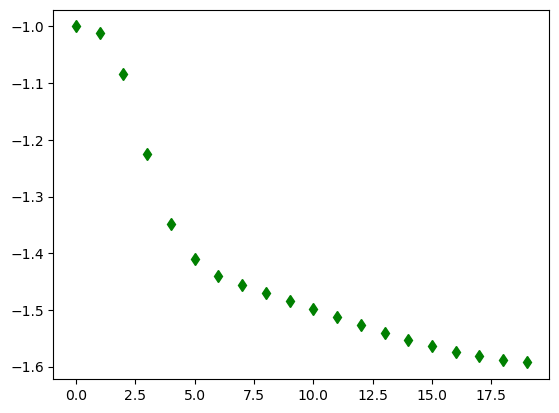

In [90]:
k = 20

plt.plot(Ep_now_open[0:k],'gd', label = 'Open quantum system')
plt.plot(Ep_kasf2[0:k],'ms', label = 'NA-QLC')
plt.plot(Ep1_now[0:k],'b*', label = 'Closed quatum system')

# plt.plot(tr[0:15], 'black')
plt.plot([-2]*k,'--', label = 'GS energy')

plt.ylabel('Energy')
plt.xlabel('Time')
plt.legend()
# plt.savefig('energy_plot.pdf')
plt.show()

## Multiple controlled gamma rates 

In [949]:
# Construct c_ops
# c_ops = 0
OPS = []
gamma_coeffs = []
pauli_strings = []

for pauli_string, coeff in data:
    if coeff != 0:  # Skip zero coefficients
        operators = [pauli_map[char] for char in pauli_string]  # Map string to operators
        tensor_op = qt.tensor(operators)  # Create the tensor product
        second_lyapunov = tensor_op.dag() * hp_qutip_op * tensor_op - hp_qutip_op
        OPS.append(second_lyapunov)
        gamma_coeffs.append(coeff*10)
        pauli_strings.append(tensor_op)
        
OPS[0]

Quantum object: dims=[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape=(32, 32), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-1.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]

In [950]:
for pauli_string, coeff in data:
    if coeff != 0:  # Skip zero coefficients
        print(pauli_string, coeff*10)

IIYZI 0.00023252783837151731
ZIIII 0.00011268080643360799
YIIII 4.1489704530253536e-05
IIIXI 0.0009827799333035642
IIIZZ 6.426757432709261e-05
IIIZI 0.0009713273520406725
IXIZI 0.0006070515050777516
IIZZI 7.645731305543452e-05
XYIII 1.7274904280455035e-05
YZIII 0.00010496745782720139
IYIZI 0.0013234637173906545
ZYIII 0.0002182156199782628
IIXZI 0.000458027313017008
IYIII 0.0019251847721199872
IZIYI 0.0016783281093320265
IZIII 0.0017639814129245782
IXIXI 0.0013390090455728252
IIIIZ 0.0001855557369977672
IZIXI 0.00034484209548697655
IIIZY 0.0002772239212166722
IIIZX 0.0004753663398936913


In [991]:
Ep_kasf1 = []
gammv = [[gamma_coeffs[i], 0] for i in range(10)]  # Example gammv values

rho = init_state
states = [init_state]
beta1 = [0, 0]

# e_ops = [op_qutip_op, hp_qutip_op, OPS]

OPS = OPS[0:10]
OPS.append(hp_qutip_op)
OPS.append(op_qutip_op)
e_ops = OPS
e_ops.reverse()

nmmc_options = {"map": "parallel"}  # options specific to nm_mcsolve
options = {"progress_bar": "enhanced", "norm_steps": 10} 

cc = []
# state_f = []
blk = []
tr = []

for i in range(1,11):
    # print(i)
    beta_s = interp1d(times1[1:i+2], beta1, kind='linear', fill_value="extrapolate")
    H_tot_2 = [hp_qutip_op, [hd_qutip_op, coeff_beta(beta_s, times1[1:i+2])]]

    gamma_int = []
    for idx in range(10):  
        gamma_int.append(CubicSpline(times1[1:i+2], np.complex128(gammv[idx])))

    c_ops = [[pauli_strings[j], gamma_int[j]] for j in range(10)]

    result = nm_mcsolve(H_tot_2, init_state, times1[2:i+3], c_ops, e_ops, ntraj = 5000, options=(options | nmmc_options))

    # result = nm_mcsolve(H_tot_2, init_state, times[1:i+2], c_ops, e_ops, ntraj = 2500, options=(options | nmmc_options))

    beta = - result.expect[0][-1] 
    # beta1.append(-result.expect[0][-1])
    beta1.insert(-1, beta)

    b = [result.expect[2+i][-1] for i in range(10)]
    blk.append(b)    

    for k in range(10):
        # print(b[k])
        if b[k] < 0.0:
            g = 0 
        elif b[k] > 0.15:
            g = - 0.15
        else:
            g = - b[k]
        if np.abs(g) < 1e-09:
            g = 0
        # print("g = ", g)
        gammv[k].insert(-1, g)

    Ep_kasf1.append(result.expect[1][-2])

    tr.append(result.trace[-1])
    # state_f.append(result.final_state)
    

 Total run time: 122.41s*] Elapsed 122.25s / Remaining 00:00:00:00         1%           ] Elapsed 2.39s / Remaining 00:00:03:56[*         5%           ] Elapsed 5.59s / Remaining 00:00:01:46[**        9%           ] Elapsed 12.94s / Remaining 00:00:02:10[**        9%           ] Elapsed 13.05s / Remaining 00:00:02:11[***      12%           ] Elapsed 16.60s / Remaining 00:00:02:01[****     18%           ] Elapsed 22.84s / Remaining 00:00:01:44[*****    22%           ] Elapsed 26.04s / Remaining 00:00:01:32[*****    23%           ] Elapsed 26.63s / Remaining 00:00:01:29[******   26%           ] Elapsed 30.28s / Remaining 00:00:01:26[******** 34%           ] Elapsed 37.55s / Remaining 00:00:01:12[*********39%           ] Elapsed 43.09s / Remaining 00:00:01:07[*********41%           ] Elapsed 44.60s / Remaining 00:00:01:04[*********41%           ] Elapsed 45.61s / Remaining 00:00:01:05[*********49%           ] Elapsed 55.41s / Remaining 00:00:00:57[*********52%           ] Elapsed 59.20s /

KeyboardInterrupt: 

## Only one gamma Lyapunov

In [1019]:
Ep_kasf1 = []
gammv = [[gamma_coeffs[i], 0] for i in range(10)]  # Example gammv values

rho = init_state
states = [init_state]
beta1 = [0, 0]

# e_ops = [op_qutip_op, hp_qutip_op, OPS]

e_ops = [op_qutip_op, hp_qutip_op, OPS[0]]

nmmc_options = {"map": "parallel"}  # options specific to nm_mcsolve
options = {"progress_bar": "enhanced", "norm_steps": 10} 

cc = []
# state_f = []
blk = []
tr = []

for i in range(1,21):
    # print(i)
    beta_s = interp1d(times1[1:i+2], beta1, kind='linear', fill_value="extrapolate")
    H_tot_2 = [hp_qutip_op, [hd_qutip_op, coeff_beta(beta_s, times1[1:i+2])]]

    gamma_int = []
    for idx in range(10):  
        gamma_int.append(CubicSpline(times1[1:i+2], np.complex128(gammv[idx])))

    c_ops = [[pauli_strings[j], gamma_int[j]] for j in range(10)]

    result = nm_mcsolve(H_tot_2, init_state, times1[2:i+3], c_ops, e_ops, ntraj = 5000, options=(options | nmmc_options))

    # result = nm_mcsolve(H_tot_2, init_state, times[1:i+2], c_ops, e_ops, ntraj = 2500, options=(options | nmmc_options))

    beta = - result.expect[0][-1] 
    # beta1.append(-result.expect[0][-1])
    beta1.insert(-1, beta)

    b = result.expect[2][-1]
    if b > 0.10:
        g = - 0.10
    else:
        g = - b
    gammv[0].insert(-1, g)

    for k in range(1,10):
        gammv[k].append(0)

    Ep_kasf1.append(result.expect[1][-2])

    tr.append(result.trace[-1])
    # state_f.append(result.final_state)
    

 Total run time:  94.10s*] Elapsed 93.98s / Remaining 00:00:00:00          2%           ] Elapsed 3.41s / Remaining 00:00:02:46[*         4%           ] Elapsed 4.88s / Remaining 00:00:01:57[**        9%           ] Elapsed 9.11s / Remaining 00:00:01:32[***      12%           ] Elapsed 12.88s / Remaining 00:00:01:34[***      15%           ] Elapsed 18.43s / Remaining 00:00:01:44[****     17%           ] Elapsed 19.92s / Remaining 00:00:01:37[******** 36%           ] Elapsed 35.67s / Remaining 00:00:01:03[*********43%           ] Elapsed 41.38s / Remaining 00:00:00:54[*********59%**         ] Elapsed 56.20s / Remaining 00:00:00:39[*********61%**         ] Elapsed 57.16s / Remaining 00:00:00:36[*********63%**         ] Elapsed 59.58s / Remaining 00:00:00:34[*********67%***        ] Elapsed 61.72s / Remaining 00:00:00:30[*********70%****       ] Elapsed 64.73s / Remaining 00:00:00:27[*********78%******     ] Elapsed 71.86s / Remaining 00:00:00:20[*********83%*******    ] Elapsed 76.84s / 

[0.002325278383715173, 1.963715343128808e-07, -0.020944410644402507, -0.09057536993577935, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]
[0.0011268080643360798, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.0004148970453025354, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.009827799333035642, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.0006426757432709261, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.009713273520406724, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.006070515050777516, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.0007645731305543453, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.00017274904280455036, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.0010496745782720138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


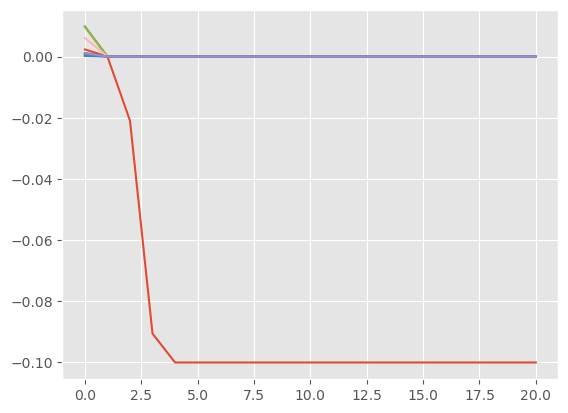

In [1020]:
for i in range(10):
    print(gammv[i][:-1])
    plt.plot(gammv[i][:-1])
    
# gammv[3]

In [1017]:
for pauli_string, coeff in data:
    if coeff != 0:  # Skip zero coefficients
        print(pauli_string, coeff)

IIYZI 0.00023252783837151731
ZIIII 0.00011268080643360799
YIIII 4.1489704530253536e-05
IIIXI 0.0009827799333035642
IIIZZ 6.426757432709261e-05
IIIZI 0.0009713273520406725
IXIZI 0.0006070515050777516
IIZZI 7.645731305543452e-05
XYIII 1.7274904280455035e-05
YZIII 0.00010496745782720139
IYIZI 0.0013234637173906545
ZYIII 0.0002182156199782628
IIXZI 0.000458027313017008
IYIII 0.0019251847721199872
IZIYI 0.0016783281093320265
IZIII 0.0017639814129245782
IXIXI 0.0013390090455728252
IIIIZ 0.0001855557369977672
IZIXI 0.00034484209548697655
IIIZY 0.0002772239212166722
IIIZX 0.0004753663398936913


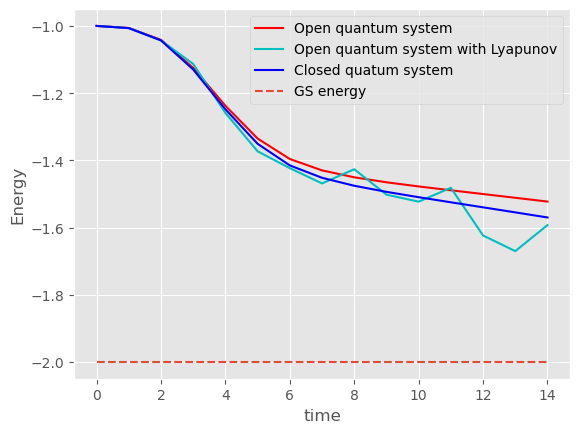

In [1021]:
plt.plot(Ep_now_open[0:15],'r', label = 'Open quantum system')
plt.plot(Ep_kasf1[0:15],'c', label = 'Open quantum system with Lyapunov')
plt.plot(Ep1_now[0:15],'b', label = 'Closed quatum system')

# plt.plot(tr[0:10], 'black')
plt.plot([-2]*15,'--', label = 'GS energy')

plt.ylabel('Energy')
plt.xlabel('time')
plt.legend()
# plt.savefig('pic13.png')
plt.show()

In [1006]:
tr

[1.0,
 1.000223138092821,
 0.9968768913621073,
 0.9970757181671736,
 0.994929843145741,
 1.0083773283445328,
 0.9784000348465637,
 0.9472376262691415,
 1.0457799146327977,
 1.0282384497325536,
 0.905077467886367,
 0.995001804010329,
 1.0324859617545705,
 0.9246477268969907,
 0.8064886677232029,
 1.1016125045408134,
 0.9271850936184249,
 0.9918761999280112,
 0.76501770332873,
 1.1187654407280871]

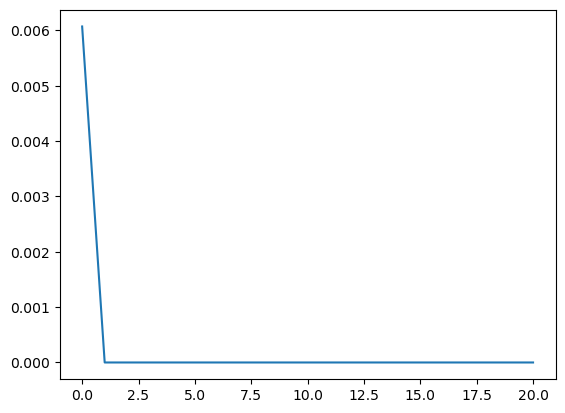

In [808]:
plt.plot(gammv[6][:-1])

In [829]:
gammv[1]

[0.0011268080643360798,
 -0.15,
 -0.15,
 -0.15,
 -0.15,
 -0.15,
 -0.15,
 -0.15,
 -0.15,
 -0.13713364141776357,
 -0.15,
 -0.15,
 -0.15,
 -0.15,
 -0.15,
 -0.15,
 -0.15,
 -0.15,
 -0.15,
 -0.15,
 -0.15,
 0]

In [813]:
len(OPS)

25

/var/folders/tf/62nqm_vs3x14pkb9r6tp4llc0000gn/T/ipykernel_69636/2690458131.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


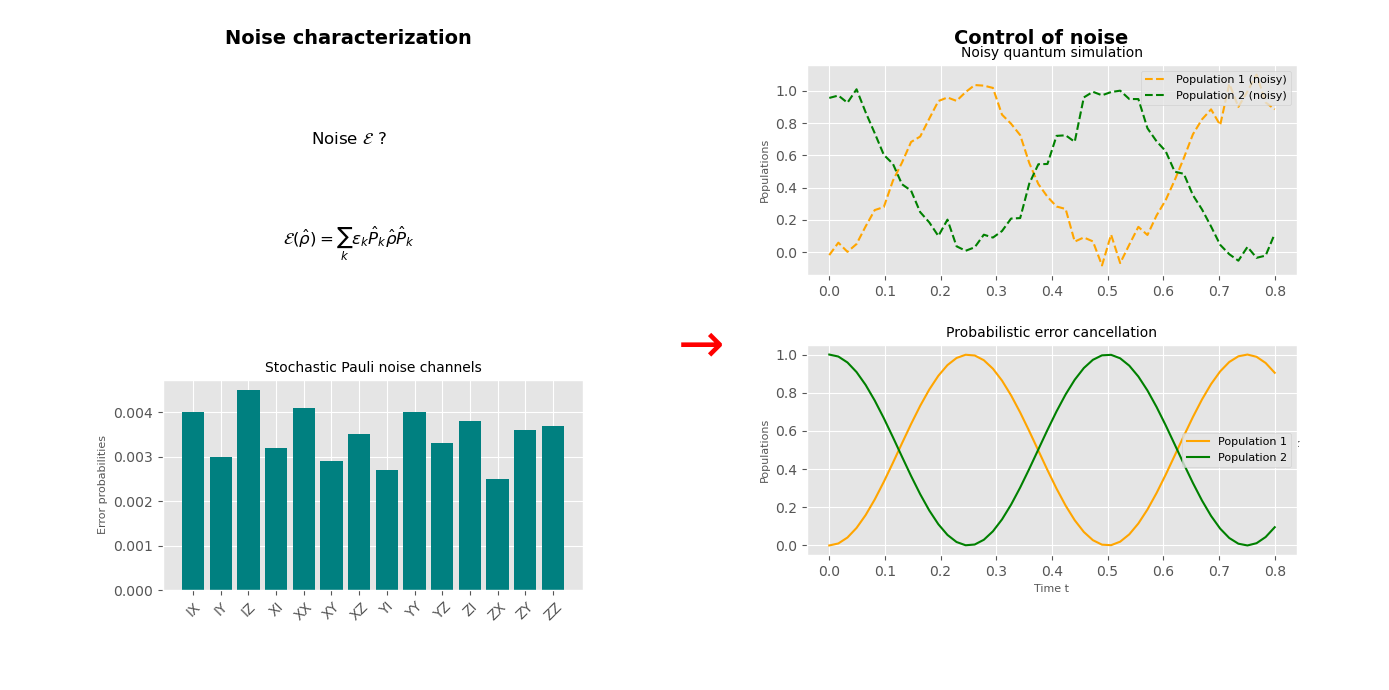

In [1061]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# Function to generate example Pauli noise data
def generate_pauli_noise_data():
    labels = ["IX", "IY", "IZ", "XI", "XX", "XY", "XZ", "YI", "YY", "YZ", "ZI", "ZX", "ZY", "ZZ"]
    values = [0.004, 0.003, 0.0045, 0.0032, 0.0041, 0.0029, 0.0035, 0.0027, 0.004, 0.0033, 0.0038, 0.0025, 0.0036, 0.0037]
    return labels, values

# Function to generate example population data
def generate_population_data():
    t = np.linspace(0, 0.8, 50)
    y1_noisy = np.sin(2 * np.pi * t) ** 2 + np.random.normal(0, 0.05, t.shape)  # Noisy
    y2_noisy = np.cos(2 * np.pi * t) ** 2 + np.random.normal(0, 0.05, t.shape)
    y1_clean = np.sin(2 * np.pi * t) ** 2
    y2_clean = np.cos(2 * np.pi * t) ** 2
    return t, y1_noisy, y2_noisy, y1_clean, y2_clean

# Initialize figure
fig = plt.figure(figsize=(14, 7))
gs = GridSpec(2, 2, width_ratios=[2, 2], height_ratios=[1, 1], figure=fig)

# -------- Left Panel: Noise Characterization --------
ax_left = fig.add_subplot(gs[:, 0], facecolor="lightyellow")
ax_left.axis("off")
ax_left.text(0.5, 0.95, "Noise characterization", fontsize=14, ha="center", fontweight="bold")

# Cycle Benchmarking and Noise Formula
ax_left.text(0.5, 0.8, r"Noise $\mathcal{E}$ ?", fontsize=12, ha="center")
ax_left.text(0.5, 0.65, r"$\mathcal{E}(\hat{\rho}) = \sum_k \epsilon_k \hat{P}_k \hat{\rho} \hat{P}_k$", 
             fontsize=12, ha="center")

# Bar chart (Stochastic Pauli noise channels)
ax_bar = fig.add_axes([0.12, 0.15, 0.3, 0.3])  # Precise position
labels, values = generate_pauli_noise_data()
ax_bar.bar(labels, values, color="teal")
ax_bar.set_title("Stochastic Pauli noise channels", fontsize=10)
ax_bar.set_ylabel("Error probabilities", fontsize=8)
ax_bar.tick_params(axis='x', labelrotation=45)

# -------- Arrow to Right Panel --------
fig.text(0.5, 0.5, r"$\rightarrow$", fontsize=40, color="red", ha="center", va="center")

# -------- Right Panel: Control of Noise --------
ax_right = fig.add_subplot(gs[:, 1], facecolor="lightyellow")
ax_right.axis("off")
ax_right.text(0.5, 0.95, "Control of noise", fontsize=14, ha="center", fontweight="bold")

# Mathematical expressions for noise control
ax_right.text(0.5, 0.87, r"$\hat{\rho}(t) = e^{\mathcal{L}t} \hat{\rho}(0) \approx \left[ \prod_{d=1}^D \mathcal{U}(\Delta t) \right] \hat{\rho}(0)$", 
              fontsize=10, ha="center")
ax_right.text(0.5, 0.77, r"$\mathcal{L}(\hat{\rho}) = -i[\hat{H}, \hat{\rho}] + \sum_k \gamma_k (\hat{P}_k \hat{\rho} \hat{P}_k - \hat{\rho})$", 
              fontsize=10, ha="center")

# Line graphs: Noisy and Noise-controlled
t, y1_noisy, y2_noisy, y1_clean, y2_clean = generate_population_data()

# Top graph: Noisy quantum simulation
ax_top = fig.add_axes([0.58, 0.6, 0.35, 0.3])
ax_top.plot(t, y1_noisy, label="Population 1 (noisy)", color="orange", linestyle="--")
ax_top.plot(t, y2_noisy, label="Population 2 (noisy)", color="green", linestyle="--")
ax_top.set_title("Noisy quantum simulation", fontsize=10)
ax_top.set_ylabel("Populations", fontsize=8)
ax_top.legend(fontsize=8)

# Bottom graph: Noise-controlled quantum simulation
ax_bottom = fig.add_axes([0.58, 0.2, 0.35, 0.3])
ax_bottom.plot(t, y1_clean, label="Population 1", color="orange")
ax_bottom.plot(t, y2_clean, label="Population 2", color="green")
ax_bottom.set_title("Probabilistic error cancellation", fontsize=10)
ax_bottom.set_xlabel("Time t", fontsize=8)
ax_bottom.set_ylabel("Populations", fontsize=8)
ax_bottom.legend(fontsize=8)

# Noise parameters on the right
ax_right.text(0.8, 0.45, r"$\gamma_k \approx \frac{\epsilon_k}{\Delta t}$", fontsize=10, ha="center")
ax_right.text(0.8, 0.35, r"$\epsilon_k^{(\mathrm{mit})} = (1 - r_k) \epsilon_k$", fontsize=10, ha="center")

# Final layout adjustments
plt.tight_layout()
plt.show()


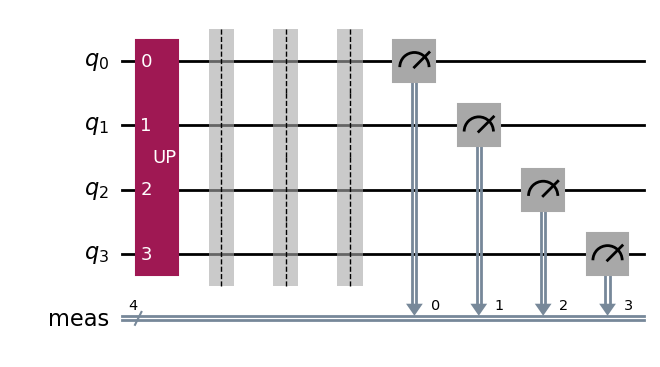

In [1077]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_circuit_layout, circuit_drawer

# Create a quantum circuit with 4 qubits
n_qubits = 4
qc = QuantumCircuit(n_qubits, name="UP")

# Initial state preparation (Ui)
# qc.append(name="Ui", qargs=[0, 1, 2, 3])  # Represents Ui block

inst = qc.to_instruction()
qc.append(inst, [0,1,2, 3])

# First Layer: UP, U1(β1), UCD(γ1)
qc.barrier()
# qc.append(name="UP", qargs=[0, 1, 2, 3])  # Represents UP block
# qc.append(name="U1(β1)", qargs=[0, 1, 2, 3])  # Represents U1(β1)
# qc.append(name="UCD(γ1)", qargs=[0, 1, 2, 3])  # Represents UCD(γ1)

# # Add barrier to separate the first and kth layer
# qc.barrier()

# # Kth Layer: UP, U1(βk), UCD(γk)
# qc.append(name="UP", qargs=[0, 1, 2, 3])  # Represents UP block
# qc.append(name="U1(βk)", qargs=[0, 1, 2, 3])  # Represents U1(βk)
# qc.append(name="UCD(γk)", qargs=[0, 1, 2, 3])  # Represents UCD(γk)

# Measurement block (abstract representation)
qc.barrier()
qc.measure_all()

# Draw the circuit
qc.draw('mpl')


/var/folders/tf/62nqm_vs3x14pkb9r6tp4llc0000gn/T/ipykernel_69636/2283271806.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


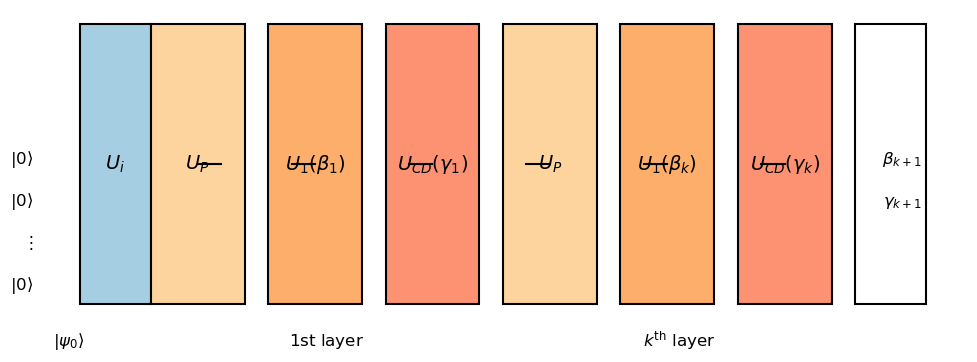

In [1079]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import matplotlib.patheffects as pe

# Function to add a text box with custom colors
def add_box(ax, xy, width, height, color, text, text_offset=(0.5, 0.5), fontsize=12):
    rect = Rectangle(xy, width, height, edgecolor='black', facecolor=color, lw=1.5, zorder=2)
    ax.add_patch(rect)
    ax.text(xy[0] + width * text_offset[0], xy[1] + height * text_offset[1],
            text, ha='center', va='center', fontsize=fontsize, zorder=3)

# Initialize figure
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')

# Colors for the boxes
colors = {
    'blue': '#a6cee3',
    'yellow': '#fdd49e',
    'orange': '#fdae6b',
    'red': '#fc9272',
    'white': '#ffffff'
}

# Initial state preparation
add_box(ax, (-1, 0.5), 1.5, 2, colors['blue'], r'$U_i$', fontsize=14)
ax.text(-2, 1.5, r"$|0\rangle$", fontsize=12, ha="right")
ax.text(-2, 1.2, r"$|0\rangle$", fontsize=12, ha="right")
ax.text(-2, 0.9, r"$\vdots$", fontsize=12, ha="right")
ax.text(-2, 0.6, r"$|0\rangle$", fontsize=12, ha="right")
ax.text(-1.25, 0.2, r"$|\psi_0\rangle$", fontsize=12, ha="center")

# First layer
add_box(ax, (0.5, 0.5), 2, 2, colors['yellow'], r'$U_P$', fontsize=14)
add_box(ax, (3, 0.5), 2, 2, colors['orange'], r'$U_1(\beta_1)$', fontsize=14)
add_box(ax, (5.5, 0.5), 2, 2, colors['red'], r'$U_{CD}(\gamma_1)$', fontsize=14)
ax.text(4.25, 0.2, r"$\text{1st layer}$", fontsize=12, ha="center")

# Kth layer
add_box(ax, (8, 0.5), 2, 2, colors['yellow'], r'$U_P$', fontsize=14)
add_box(ax, (10.5, 0.5), 2, 2, colors['orange'], r'$U_1(\beta_k)$', fontsize=14)
add_box(ax, (13, 0.5), 2, 2, colors['red'], r'$U_{CD}(\gamma_k)$', fontsize=14)
ax.text(11.75, 0.2, r"$k^\text{th} \text{ layer}$", fontsize=12, ha="center")

# Arrows between layers
for x in [1.5, 3.5, 6, 8.5, 11, 13.5]:
    ax.plot([x, x + 0.5], [1.5, 1.5], color="black", lw=1.5)

# Measurement at the end
add_box(ax, (15.5, 0.5), 1.5, 2, colors['white'], r'', fontsize=14)
ax.text(16.5, 1.5, r"$\beta_{k+1}$", fontsize=12, ha="center")
ax.text(16.5, 1.2, r"$\gamma_{k+1}$", fontsize=12, ha="center")
arrow = FancyArrowPatch((15.5, 2), (17, 2), arrowstyle="-|>", mutation_scale=10, color="black")
ax.add_patch(arrow)

# Show plot
plt.tight_layout()
plt.show()
